# Preamble

In [2]:
HomeDir = '../'
DataDir = HomeDir+'data/'
ListDir = HomeDir+'lists/'
FigDir = HomeDir+'figs/'
ListTauDir = HomeDir+'lists/coarse_tau/'

import astropy.units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.time import Time
from astroquery.gaia import Gaia
import healpy as hp
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
from tqdm import tqdm, tqdm_notebook
from time import time as tictoc
import pandas as pd
import seaborn as sns
import pandas as pd
from scipy.interpolate import griddata
from scipy import interpolate
import os

from IPython.core.display import display, HTML
from IPython.display import display, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(edgeitems=3, linewidth=200) 
pd.set_option('display.max_columns', None)
pd.set_option('max_rows',200) and pandas.set_option('max_columns',20)

plt.rcdefaults()
fontsize = 14
from matplotlib import font_manager
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import colors
rcParams['font.family'] = 'sans-serif'
font_manager.findfont('serif', rebuild_if_missing=True)
rcParams.update({'font.size':fontsize})

from MyUnits import *

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


# Functions

## Angular separation

In [2]:
def angular_sep_magn_sq(ra1, dec1, ra2, dec2):
    """Computes the magnitude of the angular separation vector for stars close to each other"""
    return ((ra1-ra2)*np.cos((dec1+dec2)/2))**2 + (dec1-dec2)**2

In [3]:
def angular_sep(ra1, dec1, ra2, dec2):
    """Computes 2d angular separations vector for stars close to each other"""
    return np.array([(ra1-ra2)*np.cos((dec1+dec2)/2), (dec1-dec2)]).T

## Equatorial to ecliptic coordinate transformation

From https://gea.esac.esa.int/archive/documentation/GEDR3/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html and section 1.5.3 of https://www.cosmos.esa.int/documents/532822/552851/vol1_all.pdf

In [4]:
rot_matrix = np.array([[1, 0, 0], [0, 0.9174821334228558, 0.39777699135300065], [0, -0.39777699135300065, 0.9174821334228558]])
ra_offset = 0.05542*arcsec
  
def fn_eq_to_ecl_array(ra, dec):
    """Function to convert the equatoria coordinates (ra, dec) to ecliptic longitude and latitude according to the Gaia reference frame"""
    """Works only if ra and dec are numpy arrays. Takes angle in deg and returns in deg"""
    
    ra_s, dec_s = ra*degree + ra_offset, dec*degree
    x_vec_eq = np.array([np.cos(dec_s)*np.cos(ra_s), np.cos(dec_s)*np.sin(ra_s), np.sin(dec_s)])
    x_vec_ecl = (rot_matrix @ x_vec_eq).T
    
    ecl_lon, ecl_lat = (np.arctan2(x_vec_ecl[:, 1], x_vec_ecl[:, 0])), np.arctan2(x_vec_ecl[:, 2], np.sqrt(x_vec_ecl[:, 0]**2 + x_vec_ecl[:, 1]**2))
    ecl_lon = ecl_lon + 2*np.pi*np.heaviside(-ecl_lon, 0) ### shift the interval from [-pi, pi] to [0, 2*pi]

    return ecl_lon/degree, ecl_lat/degree

## Healpy map and list of neighbors for each pixel

In [5]:
def fn_nb_pixel(patch_pix, radius_nb, nside, nest=True):
    """For healpy pixels in the 1d array patch_pix returns the neighbors of each pixel (disc of radius radius_nb in rad)"""
    
    ### Cartesian vectors for each pixel in patch_pix
    vec_pix_x, vec_pix_y, vec_pix_z = hp.pix2vec(nside, patch_pix, nest=nest) 
    vec_array = np.array([vec_pix_x, vec_pix_y, vec_pix_z]).T
    
    ### Loop over pixels
    nb_pix = []; 
    for i in range(len(patch_pix)):
        ### Disc around the pixel position  
        nb_pix.append(hp.query_disc(nside, vec_array[i], radius_nb, inclusive=True, nest=nest))      
    return nb_pix

## Clumps removal

In [6]:
def fn_star_count(data, disc_center, disc_radius, beta_pixel=0.03*degree):
    """Returns the pixel size (deg), the coordinates and the number of stars per pixel"""
    
    ### Determine pixelation scale (approx beta_kernel/3)
    n = round(math.log(np.sqrt(np.pi/3)/beta_pixel, 2)) 
    nside = 2**n; 
    
    ### Pixelate stars using dataframe groupby
    q_pix = np.asarray(hp.ang2pix(nside, data['ra'].to_numpy(), data['dec'].to_numpy(), nest=True, lonlat=True)) # healpy pixel number of the stars
    df_hist = pd.DataFrame({'q_pix_{}'.format(n):q_pix, 'ra':data['ra'].to_numpy(), 'dec':data['dec'].to_numpy()}).groupby(by=['q_pix_{}'.format(n)], as_index=False).sum()
    occ_pix = df_hist['q_pix_{}'.format(n)].to_numpy() # uniquely occupied pixels
    pix_count = np.bincount(q_pix); # number of stars per pixel  
    filled_pix_count = pix_count[pix_count>0]

    pix_coord = hp.pix2ang(nside, occ_pix, nest=True, lonlat=True)
    
    return np.sqrt(4*np.pi / hp.nside2npix(nside))/degree, pix_coord, filled_pix_count

In [7]:
def fn_remove_clumps(data, disc_center, disc_radius, beta_kernel=0.1*degree, f_clumps=3):
    """Removes stars falling in overdense regions, where the density is f_clumps times the local density field computed with a gaussian kernel of size beta_kernel"""
    
    ### Determine pixelation scale (approx beta_kernel/3)
    n = round(math.log(np.sqrt(np.pi/3)/(beta_kernel/3), 2)) 
    nside = 2**n; npix = hp.nside2npix(nside);
    vec = hp.pix2vec(nside, hp.ang2pix(nside, disc_center[0], disc_center[1], nest=True, lonlat=True), nest=True)
    disc_pix = hp.query_disc(nside, vec, disc_radius, nest=True, inclusive=True) # select only pixels on the sky within the selected disc
    n_disc_pix = len(disc_pix)
    disc_pix_ra, disc_pix_dec = hp.pix2ang(nside, disc_pix, nest=True, lonlat=True) # coordinates of the selected pixels
    
    ### Pixelate stars using dataframe groupby
    q_pix = np.asarray(hp.ang2pix(nside, data['ra'].to_numpy(), data['dec'].to_numpy(), nest=True, lonlat=True)) # healpy pixel number of the stars
    df_hist = pd.DataFrame({'q_pix_{}'.format(n):q_pix, 'ra':data['ra'].to_numpy(), 'dec':data['dec'].to_numpy()}).groupby(by=['q_pix_{}'.format(n)], as_index=False).sum()
    occ_pix = df_hist['q_pix_{}'.format(n)].to_numpy() # uniquely occupied pixels
    pix_count = np.bincount(q_pix); # number of stars per pixel  
    filled_pix_count = pix_count[pix_count>0]

    ### Density and coordinates per pixel
    all_density = np.zeros(npix); all_density[occ_pix] = filled_pix_count
    all_center_coord = np.zeros((npix, 2)); all_mean_coord = np.zeros((npix, 2)); 
    all_center_coord[disc_pix] = np.array([disc_pix_ra, disc_pix_dec]).T # set pix coordinates to the pix center
    all_mean_coord[disc_pix] = np.array([disc_pix_ra, disc_pix_dec]).T # set pix coordinates to the pix center
    all_mean_coord[occ_pix] = np.array([df_hist['ra'].to_numpy()/filled_pix_count, df_hist['dec'].to_numpy()/filled_pix_count]).T # set pix coordinates to the mean coordinate for non empy pixels
    
    ### To find neighboring pixels for each pixel
    radius_nb = 3*beta_kernel; # radius of neighboring pixels
    vec_pix_x, vec_pix_y, vec_pix_z = hp.pix2vec(nside, disc_pix, nest=True) 
    vec_array = np.array([vec_pix_x, vec_pix_y, vec_pix_z]).T # crtesian vectors for each pixel in patch_pix
    
    ### Loop over pixels
    density_gauss = np.zeros(n_disc_pix)
    for i in tqdm(range(n_disc_pix)):
        nb_pix = hp.query_disc(nside, vec_array[i], radius_nb, inclusive=True, nest=True)
        rel_distance_sq = angular_sep_magn_sq(all_center_coord[disc_pix[i], 0]*degree, all_center_coord[disc_pix[i], 1]*degree, 
                                              all_mean_coord[nb_pix, 0]*degree, all_mean_coord[nb_pix, 1]*degree)/(2*beta_kernel**2) # distance from the pixel
        gauss_weights = np.exp(-rel_distance_sq); 
        density_gauss[i] = sum(all_density[nb_pix]*gauss_weights)/sum(gauss_weights)  # gaussian weighted mean density 

    overdense_pixels = disc_pix[all_density[disc_pix] > f_clumps*density_gauss]
       
    return data[~np.isin(q_pix, overdense_pixels)], hp.pix2ang(2**n, overdense_pixels, nest=True, lonlat=True)

## Proper motion field subtraction

In [103]:
def fn_motion_field(data, beta_pixel=0.03*degree, sub=False, eff=False):
    """Returns the pixel size (deg), the coordinates, the pmra, pmdec and parallax per pixel"""
    
    ### Determine pixelation scale (approx beta_pixel)
    n = round(math.log(np.sqrt(np.pi/3)/beta_pixel, 2)) 
    nside = 2**n; 
    
    ### Pixelate stars using dataframe groupby
    q_pix = np.asarray(hp.ang2pix(nside, data['ra'].to_numpy(), data['dec'].to_numpy(), nest=True, lonlat=True)) # healpy pixel number of the stars
    if sub==False & eff==False:
        df_hist = pd.DataFrame({'q_pix_{}'.format(n):q_pix, 
                                'ra':data['ra'].to_numpy(), 'dec':data['dec'].to_numpy(),
                                'weighted_pmra':data['pmra'].to_numpy()/data['pmra_error'].to_numpy()**2, 
                                'weighted_pmdec':data['pmdec'].to_numpy()/data['pmdec_error'].to_numpy()**2, 
                                'weighted_parallax':data['parallax'].to_numpy()/data['parallax_error'].to_numpy()**2,
                                'pmra_w':1/data['pmra_error'].to_numpy()**2, 'pmdec_w':1/data['pmdec_error'].to_numpy()**2,
                                'parallax_w':1/data['parallax_error'].to_numpy()**2}).groupby(by=['q_pix_{}'.format(n)], as_index=False).sum()
    elif (sub==True) & (eff==False): 
        df_hist = pd.DataFrame({'q_pix_{}'.format(n):q_pix, 
                                'ra':data['ra'].to_numpy(), 'dec':data['dec'].to_numpy(),
                                'weighted_pmra':data['pmra_sub'].to_numpy()/data['pmra_error'].to_numpy()**2, 
                                'weighted_pmdec':data['pmdec_sub'].to_numpy()/data['pmdec_error'].to_numpy()**2, 
                                'weighted_parallax':data['parallax_sub'].to_numpy()/data['parallax_error'].to_numpy()**2,
                                'pmra_w':1/data['pmra_error'].to_numpy()**2, 'pmdec_w':1/data['pmdec_error'].to_numpy()**2,
                                'parallax_w':1/data['parallax_error'].to_numpy()**2}).groupby(by=['q_pix_{}'.format(n)], as_index=False).sum()
    elif (sub==True) & (eff==True): 
        df_hist = pd.DataFrame({'q_pix_{}'.format(n):q_pix, 
                                'ra':data['ra'].to_numpy(), 'dec':data['dec'].to_numpy(),
                                'weighted_pmra':data['pmra_sub'].to_numpy()/data['pm_eff_error'].to_numpy()**2, 
                                'weighted_pmdec':data['pmdec_sub'].to_numpy()/data['pm_eff_error'].to_numpy()**2, 
                                'weighted_parallax':data['parallax_sub'].to_numpy()/data['parallax_eff_error'].to_numpy()**2,
                                'pmra_w':1/data['pm_eff_error'].to_numpy()**2, 'pmdec_w':1/data['pm_eff_error'].to_numpy()**2,
                                'parallax_w':1/data['parallax_eff_error'].to_numpy()**2}).groupby(by=['q_pix_{}'.format(n)], as_index=False).sum()

    occ_pix = df_hist['q_pix_{}'.format(n)].to_numpy() # uniquely occupied pixels

    pixsize = np.sqrt(4*np.pi / hp.nside2npix(nside))/degree
    pix_coord = hp.pix2ang(nside, occ_pix, nest=True, lonlat=True)
    w_pmra = df_hist['weighted_pmra'].to_numpy()/df_hist['pmra_w'].to_numpy()
    w_pmdec = df_hist['weighted_pmdec'].to_numpy()/df_hist['pmdec_w'].to_numpy()
    w_par = df_hist['weighted_parallax'].to_numpy()/df_hist['parallax_w'].to_numpy()
    
    return pixsize, pix_coord, w_pmra, w_pmdec, w_par

In [129]:
def fn_motion_field(data, beta_pixel=0.03*degree, sub=False, eff=False):
    """Returns the pixel size (deg), the coordinates, the pmra, pmdec and parallax per pixel"""
    
    ### Determine pixelation scale (approx beta_pixel)
    n = round(math.log(np.sqrt(np.pi/3)/beta_pixel, 2)) 
    nside = 2**n; 
    
    ### Pixelate stars using dataframe groupby
    q_pix = np.asarray(hp.ang2pix(nside, data['ra'].to_numpy(), data['dec'].to_numpy(), nest=True, lonlat=True)) # healpy pixel number of the stars
    if sub==False & eff==False:
        df_hist = pd.DataFrame({'q_pix_{}'.format(n):q_pix, 
                                'ra':data['ra'].to_numpy(), 'dec':data['dec'].to_numpy(),
                                'weighted_pmra':data['pmra'].to_numpy()/data['pmra_error'].to_numpy()**2, 
                                'weighted_pmdec':data['pmdec'].to_numpy()/data['pmdec_error'].to_numpy()**2, 
                                'weighted_parallax':data['parallax'].to_numpy()/data['parallax_error'].to_numpy()**2,
                                'pmra_w':1/data['pmra_error'].to_numpy()**2, 'pmdec_w':1/data['pmdec_error'].to_numpy()**2,
                                'parallax_w':1/data['parallax_error'].to_numpy()**2}).groupby(by=['q_pix_{}'.format(n)], as_index=False).sum()
    elif (sub==True) & (eff==False): 
        df_hist = pd.DataFrame({'q_pix_{}'.format(n):q_pix, 
                                'ra':data['ra'].to_numpy(), 'dec':data['dec'].to_numpy(),
                                'weighted_pmra':data['pmra_sub'].to_numpy()/data['pmra_error'].to_numpy()**2, 
                                'weighted_pmdec':data['pmdec_sub'].to_numpy()/data['pmdec_error'].to_numpy()**2, 
                                'weighted_parallax':data['parallax_sub'].to_numpy()/data['parallax_error'].to_numpy()**2,
                                'pmra_w':1/data['pmra_error'].to_numpy()**2, 'pmdec_w':1/data['pmdec_error'].to_numpy()**2,
                                'parallax_w':1/data['parallax_error'].to_numpy()**2}).groupby(by=['q_pix_{}'.format(n)], as_index=False).sum()
    elif (sub==True) & (eff==True): 
        df_hist = pd.DataFrame({'q_pix_{}'.format(n):q_pix, 
                                'ra':data['ra'].to_numpy(), 'dec':data['dec'].to_numpy(),
                                'weighted_pmra':data['pmra_sub'].to_numpy()/data['pm_eff_error'].to_numpy(), 
                                'weighted_pmdec':data['pmdec_sub'].to_numpy()/data['pm_eff_error'].to_numpy(), 
                                'weighted_parallax':data['parallax_sub'].to_numpy()/data['parallax_eff_error'].to_numpy(),
                                'pmra_w':1, 'pmdec_w':1,
                                'parallax_w':1}).groupby(by=['q_pix_{}'.format(n)], as_index=False).sum()

    occ_pix = df_hist['q_pix_{}'.format(n)].to_numpy() # uniquely occupied pixels

    pixsize = np.sqrt(4*np.pi / hp.nside2npix(nside))/degree
    pix_coord = hp.pix2ang(nside, occ_pix, nest=True, lonlat=True)
    w_pmra = df_hist['weighted_pmra'].to_numpy()/df_hist['pmra_w'].to_numpy()
    w_pmdec = df_hist['weighted_pmdec'].to_numpy()/df_hist['pmdec_w'].to_numpy()
    w_par = df_hist['weighted_parallax'].to_numpy()/df_hist['parallax_w'].to_numpy()
    
    return pixsize, pix_coord, w_pmra, w_pmdec, w_par

In [9]:
def fn_back_field_sub(data, disc_pix, nb_pixel_array, n, beta_kernel=0.1*degree, sub=False):
    """Creates a local map of the pm field and the parallax using a gaussian distance kenerl and subtracts the mean fields from each star pm and parallax"""
    """If sub=True, the subtracted motions from a previous iteration are used"""
    
    nside = 2**n; npix = hp.nside2npix(nside);
    
    ### Pixelate stars using dataframe groupby
    #print('Pixelate ...')
    if sub==False:
        df_hist = pd.DataFrame({'q_pix_{}'.format(n):data['q_pix_{}'.format(n)].to_numpy(), 
                                'ra':data['ra'].to_numpy(), 'dec':data['dec'].to_numpy(),
                                'weighted_pmra':data['pmra'].to_numpy()/data['pmra_error'].to_numpy()**2, 
                                'weighted_pmdec':data['pmdec'].to_numpy()/data['pmdec_error'].to_numpy()**2, 
                                'weighted_parallax':data['parallax'].to_numpy()/data['parallax_error'].to_numpy()**2,
                                'pmra_w':1/data['pmra_error'].to_numpy()**2, 'pmdec_w':1/data['pmdec_error'].to_numpy()**2,
                                'parallax_w':1/data['parallax_error'].to_numpy()**2}).groupby(by=['q_pix_{}'.format(n)], as_index=False).sum()
    else:
        df_hist = pd.DataFrame({'q_pix_{}'.format(n):data['q_pix_{}'.format(n)].to_numpy(), 
                                'ra':data['ra'].to_numpy(), 'dec':data['dec'].to_numpy(),
                                'weighted_pmra':data['pmra_sub'].to_numpy()/data['pmra_error'].to_numpy()**2, 
                                'weighted_pmdec':data['pmdec_sub'].to_numpy()/data['pmdec_error'].to_numpy()**2, 
                                'weighted_parallax':data['parallax_sub'].to_numpy()/data['parallax_error'].to_numpy()**2,
                                'pmra_w':1/data['pmra_error'].to_numpy()**2, 'pmdec_w':1/data['pmdec_error'].to_numpy()**2,
                                'parallax_w':1/data['parallax_error'].to_numpy()**2}).groupby(by=['q_pix_{}'.format(n)], as_index=False).sum()
    occ_pix = df_hist['q_pix_{}'.format(n)].to_numpy() # uniquely occupied pixels
    pix_count = np.bincount(data['q_pix_{}'.format(n)].to_numpy()); # number of stars per pixel  
    filled_pix_count = pix_count[pix_count>0]
    
    ### Full sky pixel arrays
    disc_pix_ra, disc_pix_dec = hp.pix2ang(nside, disc_pix, nest=True, lonlat=True) # coordinates of the selected pixels
    all_center_coord = np.zeros((npix, 2)); all_mean_coord = np.zeros((npix, 2)); 
    all_center_coord[disc_pix] = np.array([disc_pix_ra, disc_pix_dec]).T # set pix coordinates to the pix center
    all_mean_coord[disc_pix] = np.array([disc_pix_ra, disc_pix_dec]).T # set pix coordinates to the pix center
    all_mean_coord[occ_pix] = np.array([df_hist['ra'].to_numpy()/filled_pix_count, df_hist['dec'].to_numpy()/filled_pix_count]).T # set pix coordinates to the mean coordinate

    all_mean_pm = np.zeros((npix, 2)); all_mean_parallax = np.zeros(npix) 
    all_mean_pm[occ_pix] = np.array([df_hist['weighted_pmra'].to_numpy()/df_hist['pmra_w'].to_numpy(), 
                                     df_hist['weighted_pmdec'].to_numpy()/df_hist['pmdec_w'].to_numpy()]).T    
    all_mean_parallax[occ_pix] = df_hist['weighted_parallax'].to_numpy()/df_hist['parallax_w'].to_numpy()
    
    n_disc_pix = len(disc_pix)
    pm_gauss = np.zeros((n_disc_pix, 2)); parallax_gauss = np.zeros(n_disc_pix)

    #print('Loop over pixels ...')
    ### Loop over pixels
    for i in tqdm(range(n_disc_pix)):
        nb_pix = nb_pixel_array[i]     
        rel_distance_sq = angular_sep_magn_sq(all_center_coord[disc_pix[i], 0]*degree, all_center_coord[disc_pix[i], 1]*degree, 
                                              all_mean_coord[nb_pix, 0]*degree, all_mean_coord[nb_pix, 1]*degree)/(2*beta_kernel**2)
        gauss_weights = np.exp(-rel_distance_sq); sum_gauss_weights = sum(gauss_weights)
        pm_gauss[i, 0] = sum(all_mean_pm[nb_pix, 0]*gauss_weights)/sum_gauss_weights  # gaussian weighted mean pm in ra
        pm_gauss[i, 1] = sum(all_mean_pm[nb_pix, 1]*gauss_weights)/sum_gauss_weights  # gaussian weighted mean pm in dec
        parallax_gauss[i] = sum(all_mean_parallax[nb_pix]*gauss_weights)/sum_gauss_weights
        
    #print('Interpolate ...')
    ### Interpolation of the velocity field
    pmra_interp = griddata((all_mean_coord[disc_pix, 0], all_mean_coord[disc_pix, 1]), pm_gauss[:, 0], (data['ra'].to_numpy(), data['dec'].to_numpy()), method='linear', fill_value=0)
    pmdec_interp = griddata((all_mean_coord[disc_pix, 0], all_mean_coord[disc_pix, 1]), pm_gauss[:, 1], (data['ra'].to_numpy(), data['dec'].to_numpy()), method='linear', fill_value=0)
    parallax_interp = griddata((all_mean_coord[disc_pix, 0], all_mean_coord[disc_pix, 1]), parallax_gauss, (data['ra'].to_numpy(), data['dec'].to_numpy()), method='linear', fill_value=0)

    #print('Subtract ...')
    if sub==False:
        data['pmra_sub'] = data['pmra'].to_numpy() - pmra_interp; data['pmdec_sub'] = data['pmdec'].to_numpy() - pmdec_interp;
        data['parallax_sub'] = data['parallax'].to_numpy() - parallax_interp
    else:
        data['pmra_sub'] = data['pmra_sub'].to_numpy() - pmra_interp; data['pmdec_sub'] = data['pmdec_sub'].to_numpy() - pmdec_interp;
        data['parallax_sub'] = data['parallax_sub'].to_numpy() - parallax_interp        
    
    return None

In [10]:
def fn_rem_outliers(data, pm_esc, D_s, n_sigma_out=3):
    """Remove stars with pm or parallax more than n_sigma_out sigma away from the expected value"""
    """Returns cleaned stars and fraction of outliers removed"""
    old_len = len(data)
    new_data = data[( np.sqrt(data['pmra_sub'].to_numpy()**2 + data['pmdec_sub'].to_numpy()**2) < 
                      (pm_esc + n_sigma_out*np.sqrt(data['pmra_error'].to_numpy()**2 + data['pmdec_error'].to_numpy()**2)) ) &
                    ( np.abs(data['parallax_sub'].to_numpy()) < (1/D_s + n_sigma_out*data['parallax_error'].to_numpy()) )]
    return new_data, 1-len(new_data)/old_len

In [11]:
def fn_rem_edges(data, disc_center, disc_radius, n_iter_sub=3, beta_kernel=0.1*degree):
    """Remove stars (n_iter_sub+1)*beta_kernel times from the edges"""
    center_sky_coord = SkyCoord(ra = disc_center[0] * u.deg, dec = disc_center[1] * u.deg)
    data_sky_coord = SkyCoord(ra = data['ra'].to_numpy() * u.deg, dec = data['dec'].to_numpy() * u.deg)
    data_r = data_sky_coord.separation(center_sky_coord).value*degree
        
    return data[data_r < (disc_radius - (n_iter_sub+1)*beta_kernel)]

## Effective weights

In [12]:
def fn_effective_err(data, disc_center, gmag_bin_size=0.1):
    
    ### Bin in g magnitude and radial distance from the center
    data_g = data['phot_g_mean_mag'].to_numpy()
    min_g, max_g = np.min(data_g), np.max(data_g)
    bins_g = np.arange(min_g, max_g+gmag_bin_size, gmag_bin_size)
    q_bin_g = np.digitize(data_g, bins_g)-1         

    ### Histograms with mean pm and parallax dispersion per bin
    counts = np.histogram(data_g, bins=bins_g, weights=None)[0]
    pm_sq = np.histogram(data_g, bins=bins_g, weights=(data['pmra_sub'].to_numpy()**2 + data['pmdec_sub'].to_numpy()**2))[0]
    par_sq = np.histogram(data_g, bins=bins_g, weights=(data['parallax_sub'].to_numpy()**2))[0]

    sigma_pm_eff_hist = np.sqrt(np.divide(pm_sq, counts, out=np.zeros_like(pm_sq), where=counts!=0))
    sigma_par_eff_hist = np.sqrt(np.divide(par_sq, counts, out=np.zeros_like(par_sq), where=counts!=0))

    return bins_g, counts, sigma_pm_eff_hist, sigma_par_eff_hist

In [13]:
def fn_avg_err(data, disc_center, gmag_bin_size=0.1):
    
    ### Bin in g magnitude and radial distance from the center
    data_g = data['phot_g_mean_mag'].to_numpy()
    min_g, max_g = np.min(data_g), np.max(data_g)
    bins_g = np.arange(min_g, max_g+gmag_bin_size, gmag_bin_size)
    q_bin_g = np.digitize(data_g, bins_g)-1         

    ### Histograms with mean pm and parallax error per bin
    counts = np.histogram(data_g, bins=bins_g, weights=None)[0]
    pm_sq = np.histogram(data_g, bins=bins_g, weights=(data['pmra_error'].to_numpy()**2 + data['pmdec_error'].to_numpy()**2))[0]
    par_sq = np.histogram(data_g, bins=bins_g, weights=(data['parallax_error'].to_numpy()**2))[0]

    sigma_pm_err_hist = np.sqrt(np.divide(pm_sq, counts, out=np.zeros_like(pm_sq), where=counts!=0))
    sigma_par_err_hist = np.sqrt(np.divide(par_sq, counts, out=np.zeros_like(par_sq), where=counts!=0))

    ### Histograms with mean pm and parallax effective error per bin
    pm_eff_sq = np.histogram(data_g, bins=bins_g, weights=(data['pm_eff_error'].to_numpy()**2))[0]
    par_eff_sq = np.histogram(data_g, bins=bins_g, weights=(data['parallax_eff_error'].to_numpy()**2))[0]

    sigma_pm_eff_hist = np.sqrt(np.divide(pm_eff_sq, counts, out=np.zeros_like(pm_eff_sq), where=counts!=0))
    sigma_par_eff_hist = np.sqrt(np.divide(par_eff_sq, counts, out=np.zeros_like(par_eff_sq), where=counts!=0))

    return bins_g, sigma_pm_err_hist, sigma_par_err_hist, sigma_pm_eff_hist, sigma_par_eff_hist

In [14]:
def fn_effective_w(data, disc_center, gmag_bin_size=0.1, rad_bin_size=1):
    """Compute effective pm and parallax dispersion in gmag and radial bins"""
    
    ### Bin in g magnitude and radial distance from the center
    data_g = data['phot_g_mean_mag'].to_numpy()
    min_g, max_g = np.min(data_g), np.max(data_g)
    bins_g = np.arange(min_g, max_g+gmag_bin_size, gmag_bin_size)
    q_bin_g = np.digitize(data_g, bins_g)-1         
    
    center_sky_coord = SkyCoord(ra = disc_center[0] * u.deg, dec = disc_center[1] * u.deg)
    data_sky_coord = SkyCoord(ra = data['ra'].to_numpy() * u.deg, dec = data['dec'].to_numpy() * u.deg)
    data_r = data_sky_coord.separation(center_sky_coord).value
    bins_r = np.arange(0, np.max(data_r)+rad_bin_size, rad_bin_size)
    q_bin_r = np.digitize(data_r, bins_r)-1     
    
    ### Histograms with mean pm and parallax dispersion per bin
    counts = np.histogram2d(data_g, data_r, bins=[bins_g, bins_r], weights=None)[0]
    pm_sq = np.histogram2d(data_g, data_r, bins=[bins_g, bins_r], weights=(data['pmra_sub'].to_numpy()**2 + data['pmdec_sub'].to_numpy()**2))[0]
    par_sq = np.histogram2d(data_g, data_r, bins=[bins_g, bins_r], weights=(data['parallax_sub'].to_numpy()**2))[0]

    sigma_pm_eff_hist = np.sqrt(np.divide(pm_sq, counts, out=np.zeros_like(pm_sq), where=counts!=0))
    sigma_par_eff_hist = np.sqrt(np.divide(par_sq, counts, out=np.zeros_like(par_sq), where=counts!=0))

    ### Set to zero for bins that have less than 30 stars
    sigma_pm_eff_hist[counts < 30] = 0
    sigma_par_eff_hist[counts < 30] = 0
    
    ### Add effective error columns (for each star, take the max between the instrumental and effective dispersion)
    data['pm_eff_error'] = np.max(np.array([sigma_pm_eff_hist[q_bin_g, q_bin_r], np.sqrt(data['pmra_error'].to_numpy()**2 + data['pmdec_error'].to_numpy()**2)]), axis=0)
    data['parallax_eff_error'] = np.max(np.array([sigma_par_eff_hist[q_bin_g, q_bin_r], data['parallax_error'].to_numpy()]), axis=0)
    
    return None

## Template

### Matched filters

In [ ]:
# Uploading lists for the G_0 function and it's derivative. G_0 is the enclosed lens mass within a cylinder oriented along the line of sight. 
# See Eq.(3.10)=(3.11) of 1804.01991 or Eq.(2) of 2002.01938
# For the NFW truncated lens profile given by Eq.(3) of 2002.01938 the enclosed mass cannot be computed analytically. We use an interpolation function.

logxG0_list = np.loadtxt(ListDir+'G0NFWtrunc.txt');  logxG0_prime_list = np.loadtxt(ListDir+'G0pNFWtrunc.txt');  #logxG0_second_list = np.loadtxt(ListDir+'G0ppNFWtrunc.txt');
logG0_fnc = interpolate.interp1d(logxG0_list[:, 0], logxG0_list[:, 1], kind='cubic', bounds_error=False, fill_value=(logxG0_list[0, 1], logxG0_list[-1, 1]))
logG0_p_fnc = interpolate.interp1d(logxG0_prime_list[:, 0], logxG0_prime_list[:, 1], kind='cubic', bounds_error=False, fill_value=(logxG0_prime_list[0, 1], logxG0_prime_list[-1, 1]))

"Returns the lens enclosed mass within the distance x = beta/beta_l"
def G0_fnc(x): return np.power(10, logG0_fnc(np.log10(x+1E-20)))
def G0_p_fnc(x): return np.power(10, logG0_p_fnc(np.log10(x+1E-20)))

def dipole_mf(b_l, b_vec):
    """Returns the pm dipole-like profile"""
    b_norm = np.sqrt(b_vec[:, 0]**2 + b_vec[:, 1]**2)
    b_hat = np.array([b_vec[:,0]/(b_norm+1E-20), b_vec[:,1]/(b_norm+1E-20)]).T; x = b_norm/b_l
    G0_over_xsq = G0_fnc(x)/(x**2+1E-20); G0p_over_x = G0_p_fnc(x)/(x+1E-20)

    remove_inf = np.heaviside(b_norm, 0) # set to zero values corresponding to b_vec = [0, 0], remove infinity at the origin
    
    dipole_ra = np.array([(G0_over_xsq*(2*b_hat[:, 0]*b_hat[:, 0] - 1) - G0p_over_x*b_hat[:,0]*b_hat[:,0])*remove_inf, 
                          (G0_over_xsq*(2*b_hat[:, 1]*b_hat[:, 0]) - G0p_over_x*b_hat[:, 1]*b_hat[:, 0])*remove_inf]).T
    dipole_dec = np.array([(G0_over_xsq*(2*b_hat[:, 0]*b_hat[:, 1]) - G0p_over_x*b_hat[:, 1]*b_hat[:, 0])*remove_inf, 
                           (G0_over_xsq*(2*b_hat[:, 1]*b_hat[:, 1] - 1) - G0p_over_x*b_hat[:, 1]*b_hat[:, 1])*remove_inf]).T
    isotropic_dipole_magn = (G0_over_xsq**2 + 0.5*(G0p_over_x**2-2*G0_over_xsq*G0p_over_x))*remove_inf # for the normalization; see Eq. (13) of 2002.01938
    
    ### Compute the monopole to check the background
    monopole = np.array([(G0_over_xsq*b_hat[:, 0])*remove_inf, (G0_over_xsq*b_hat[:, 1])*remove_inf]).T
    monopole_magn = G0_over_xsq**2*remove_inf
        
    return dipole_ra, dipole_dec, isotropic_dipole_magn, monopole, monopole_magn

In [16]:
def parallax_mf(b_l, b_vec, sinb):
    """Returns the parallax profile"""
    b_norm = np.sqrt(b_vec[:, 0]**2 + b_vec[:, 1]**2)
    b_hat = np.array([b_vec[:,0]/(b_norm+1E-20), b_vec[:,1]/(b_norm+1E-20)]).T; x = b_norm/b_l
    G0_over_xsq = G0_fnc(x)/(x**2+1E-20); G0p_over_x = G0_p_fnc(x)/(x+1E-20)

    remove_inf = np.heaviside(b_norm, 0) # set to zero values corresponding to b_vec = [0, 0], remove infinity at the origin
    
    return -(G0_over_xsq*(2*b_hat[:, 1]**2-1)*(1-sinb**2) + G0p_over_x*(1 - (1-sinb**2)*b_hat[:, 1]**2))/(1+sinb**2)*remove_inf  

### Scan

In [19]:
def fn_template_scan(nside, coarse_scan_pix):
    """Compute the template at the locations given by coarse_scan_pix"""
    """Includes pm and parallax templates"""
    
    coarse_scan_coord = hp.pix2ang(nside, coarse_scan_pix, nest=True, lonlat=True) # coordinates of the template locations

    ### Cartesian vectors for each pixel in coarse_scan_pix
    vec_pix_x, vec_pix_y, vec_pix_z = hp.pix2vec(nside, coarse_scan_pix, nest=True) 
    vec_array = np.array([vec_pix_x, vec_pix_y, vec_pix_z]).T
    
    n_loc = len(coarse_scan_pix)
    tau_mu_ra, tau_mu_dec, tau_mu_norm = np.zeros(n_loc), np.zeros(n_loc), np.zeros(n_loc)
    tau_mu_mon, tau_mu_mon_norm = np.zeros(n_loc), np.zeros(n_loc)
    tau_par, tau_par_norm = np.zeros(n_loc), np.zeros(n_loc)
    
    for i in tqdm(range(n_loc)):
        nb_pix_i = hp.query_disc(nside, vec_array[i], n_betat*beta_t, inclusive=True, nest=True) # disc around the template position 

        stars_in = ((q_pix >= nb_pix_i[0]) & (q_pix <= nb_pix_i[-1])) # first reduce the total number of stars   
        nb_stars = np.isin(q_pix[stars_in], nb_pix_i, assume_unique=False, invert=False) # keep only stars within the neighboring pixels 
        #nb_stars = np.intersect1d(q_pix[stars_in], nb_pix_i, assume_unique=False, return_indices=True)[1] # this does not work because it returns only the unique list of common values! we also want repeated entries

        ### Pm template
        beta_it = angular_sep(coarse_scan_coord[0][i]*degree, coarse_scan_coord[1][i]*degree, data_ra[stars_in][nb_stars]*degree, data_dec[stars_in][nb_stars]*degree)
        mu_ra, mu_dec, mu_sq, mu_mon, mu_mon_sq = dipole_mf(beta_t, beta_it)

        tau_mu_norm[i] = np.sqrt(sum(mu_sq/pm_w_sq[stars_in][nb_stars])) ## normalization
        tau_mu_ra[i] = sum((mu_ra[:, 0]*weighted_pmra[stars_in][nb_stars] + mu_ra[:, 1]*weighted_pmdec[stars_in][nb_stars]))
        tau_mu_dec[i] = sum((mu_dec[:, 0]*weighted_pmra[stars_in][nb_stars] + mu_dec[:, 1]*weighted_pmdec[stars_in][nb_stars]))
        
        tau_mu_mon_norm[i] = np.sqrt(sum(mu_mon_sq/pm_w_sq[stars_in][nb_stars])) ## normalization
        tau_mu_mon[i] = sum((mu_mon[:, 0]*weighted_pmra[stars_in][nb_stars] + mu_mon[:, 1]*weighted_pmdec[stars_in][nb_stars]))
        
        ### Parallax template
        beta_it_ecl = angular_sep(coarse_scan_coord_ecl[0][i]*degree, coarse_scan_coord_ecl[1][i]*degree, data_ecl_lon[stars_in][nb_stars]*degree, data_ecl_lat[stars_in][nb_stars]*degree)
        par_t = parallax_mf(beta_t, beta_it_ecl, np.sin(coarse_scan_coord_ecl[1][i]*degree)) 
        
        tau_par_norm[i] = np.sqrt(sum(par_t**2/par_w_sq[stars_in][nb_stars])) ## normalization
        tau_par[i] =  sum(par_t*weighted_par[stars_in][nb_stars])
        
    np.save(ListTauDir+'tau_b'+beta_t_deg+'_'+str(i_step), np.array([coarse_scan_coord[0], coarse_scan_coord[1], tau_mu_ra, tau_mu_dec, tau_mu_norm, tau_mu_mon, tau_mu_mon_norm, tau_par, tau_par_norm]).T)
    
    return None

# Run

## Preamble

In [20]:
### Define disc on the sky where the analysis is done
disc_radius = 5*degree; disc_center = np.array([81.28,-69.78]) #np.array([78.77, -69.01]); 

In [21]:
### Import the data
### Before removing stars that do not have a phot_g_mean_mag measurement the n of rows is 16720427
### After it's 16709625
data = pd.read_csv(DataDir+'LMC_disc_5.csv')  
data.shape

(16709625, 18)

In [22]:
### Parameters for data cleaning
beta_kernel_clump_1 = 0.1*degree # gaussian kernel for first clump removal
f_clump_1 = 2 # multiple of the avg density field for first clump removal
beta_kernel_clump_2 = 0.06*degree # gaussian kernel for second clump removal
f_clump_2 = 3 # multiple of the avg density field for second clump removal

beta_kernel_sub_0 = 0.1*degree; # gaussian kernel for background subtraction 
beta_kernel_sub = 0.06*degree; # 0.1*degree; gaussian kernel for background subtraction 
pm_esc = 0.2; D_s = 50; n_sigma_out_0 = 5; n_sigma_out = 3; # escape velocity, distance of the stars given in kpc, number of sigmas for outlier removal
n_iter_sub = 3; #f_out_min = 1E-5 # number of iterations for the background subtraction

## First cleaning

### Execution

First compute the average pm and parallax fields using a gaussian distance kernel of size beta_kernel_sub_0 = 0.1 deg

In [23]:
### Pixelation for background subtraction
print('Background subtraction at scale', beta_kernel_sub_0/degree, 'degree')
n = round(math.log(np.sqrt(np.pi/3)/(beta_kernel_sub_0/3), 2))  # 11; pixelation scale at approx 1/3 of beta_kernel
nside = 2**n; npix = hp.nside2npix(nside);
print('nside =',nside,', npix =',npix)
print('linear pixel size =',str(np.sqrt(4*np.pi / npix) / arcsec)[0:7],' arcsec =', str(np.sqrt(4*np.pi / npix) / degree)[0:7],' degree')
vec = hp.pix2vec(nside, hp.ang2pix(nside, disc_center[0], disc_center[1], nest=True, lonlat=True), nest=True)
disc_pix = hp.query_disc(nside, vec, disc_radius, nest=True, inclusive=True) # pixels on the sky within the selected disc
print('number of pixels in the disc =', len(disc_pix))

Background subtraction at scale 0.1 degree
nside = 2048 , npix = 50331648
linear pixel size = 103.064  arcsec = 0.02862  degree
number of pixels in the disc = 96630


In [24]:
### Stars healpy pixel number
q_pix = np.asarray(hp.ang2pix(nside, data['ra'].to_numpy(), data['dec'].to_numpy(), nest=True, lonlat=True)) # healpy pixel number of the stars
data['q_pix_{}'.format(n)] = q_pix
data.shape

(16709625, 19)

In [25]:
### Find neighboring pixels for each pixel
radius_nb = 3*beta_kernel_sub_0;
nb_pixel_list = fn_nb_pixel(disc_pix, radius_nb, nside, nest=True)
len(nb_pixel_list), len(nb_pixel_list[0]), len(nb_pixel_list[55])

(96630, 400, 401)

In [26]:
### Computing the avg pm field 
fn_back_field_sub(data, disc_pix, nb_pixel_list, n, beta_kernel=beta_kernel_sub_0, sub=False)

100%|██████████| 96630/96630 [00:24<00:00, 3869.43it/s]


Remove clumps

In [27]:
### Density map of the original data
pix_size, coord, density = fn_star_count(data, disc_center, disc_radius, beta_pixel=0.03*degree)

In [28]:
### First clump removal at angular scale beta_kernel_clump_1 = 0.1 deg. Removing clumps which are f_clump_1 = 2 denser
data, clumps_1 = fn_remove_clumps(data, disc_center, disc_radius, beta_kernel=beta_kernel_clump_1, f_clumps=f_clump_1)
print(data.shape)

### Second clump removal at angular scale beta_kernel_clump_2 = 0.06 deg. Removing clumps which are f_clump_1 = 3 denser
data, clumps_2 = fn_remove_clumps(data, disc_center, disc_radius, beta_kernel=beta_kernel_clump_2, f_clumps=f_clump_2)
print(data.shape)

100%|██████████| 96630/96630 [00:17<00:00, 5389.80it/s]


(16649459, 22)


100%|██████████| 384816/384816 [01:32<00:00, 4165.17it/s]


(16635977, 22)


In [29]:
np.save(ListDir+'LMC_clumps_1', clumps_1)
np.save(ListDir+'LMC_clumps_2', clumps_2)

In [29]:
### Density map after the clumps removal
pix_size, coord_clean, density_clean = fn_star_count(data, disc_center, disc_radius, beta_pixel=0.03*degree)

In [30]:
### Removal of pm and parallax outliers at more than 5 signa
data, f_out = fn_rem_outliers(data, pm_esc, D_s, n_sigma_out_0)
print('Fraction of outliers removed: '+str(f_out*100)[:7]+' %')

Fraction of outliers removed: 4.70165 %


Additional cuts

In [31]:
old_len = len(data)
#data = data[(data['parallax']/data['parallax_error'] < 2) & (data['ruwe'] < 1.4) &
#            (data['ipd_gof_harmonic_amplitude'] < 0.4) & (data['ipd_frac_multi_peak'] < 40) & (data['ipd_frac_odd_win'] < 40) &
#            (~np.isnan(data['phot_g_mean_mag']))]  ### frac of stars surviving is 88.5 %
data = data[(data['ruwe'] < 1.4) & (data['ipd_gof_harmonic_amplitude'] < 0.4) & 
            (data['ipd_frac_multi_peak'] < 40) & (data['ipd_frac_odd_win'] < 40)]  ### Not using the cut on the parallax
len(data)/old_len

0.9290109488500904

In [33]:
# Exporting the data file as a csv file
data.to_csv(DataDir+'LMC_disc_5_clean.csv', index=False)

### Plots

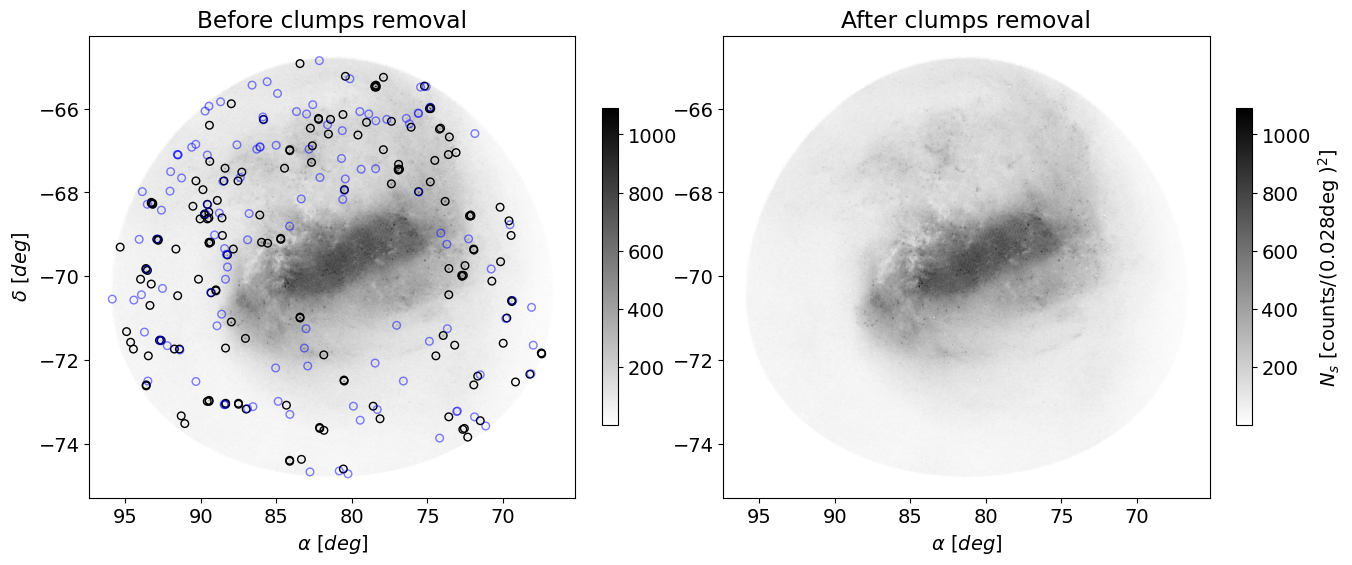

In [35]:
fig, ax = plt.subplots(1, 2,figsize=(15,6))
image = ax[0].scatter(coord[0], coord[1], s=0.2, alpha=1, c=density, cmap="binary")
ax[0].scatter(clumps_1[0], clumps_1[1], s=30, facecolors='none', edgecolors='k')
ax[0].scatter(clumps_2[0], clumps_2[1], s=30, alpha=0.5, facecolors='none', edgecolors='b')
ax[0].invert_xaxis()
ax[0].set_xlabel(r'$\alpha\ [deg]$'); ax[0].set_ylabel(r'$\delta\ [deg]$')
ax[0].set_title('Before clumps removal')
cbar = fig.colorbar(image, ax=ax[0],fraction=0.03);
#cbar.set_label(r'$N_s$ [counts/('+str(pix_size)[:5]+'deg $)^2$]')

image = ax[1].scatter(coord_clean[0], coord_clean[1], s=0.2, alpha=1, c=density_clean, cmap="binary")
#ax[1].scatter(clumps01[0], clumps01[1], s=30, facecolors='none', edgecolors='k')
#ax[1].scatter(clumps006[0], clumps006[1], s=30, alpha=0.5, facecolors='none', edgecolors='b')
ax[1].invert_xaxis()
ax[1].set_xlabel(r'$\alpha\ [deg]$');
ax[1].set_title('After clumps removal');
cbar = fig.colorbar(image, ax=ax[1],fraction=0.03);
cbar.set_label(r'$N_s$ [counts/('+str(pix_size)[:5]+'deg $)^2$]')

In [32]:
### Pm and parallax fields before subtraction
pix_size, coord, pmra_field, pmdec_field, parallax_field = fn_motion_field(data, beta_pixel=0.03*degree, sub=False, eff=False)

### Pm and parallax fields after subtraction
pix_size, coord_sub, pmra_field_sub, pmdec_field_sub, parallax_field_sub = fn_motion_field(data, beta_pixel=0.03*degree, sub=True, eff=False)

print(np.mean(parallax_field), np.mean(pmra_field), np.mean(pmdec_field))
print(np.mean(parallax_field_sub), np.mean(pmra_field_sub), np.mean(pmdec_field_sub))

-0.0042347298040843855 1.8166812206220606 0.37621905167661746
-0.010431371258886546 -0.032154984010128264 -0.16188855926655227


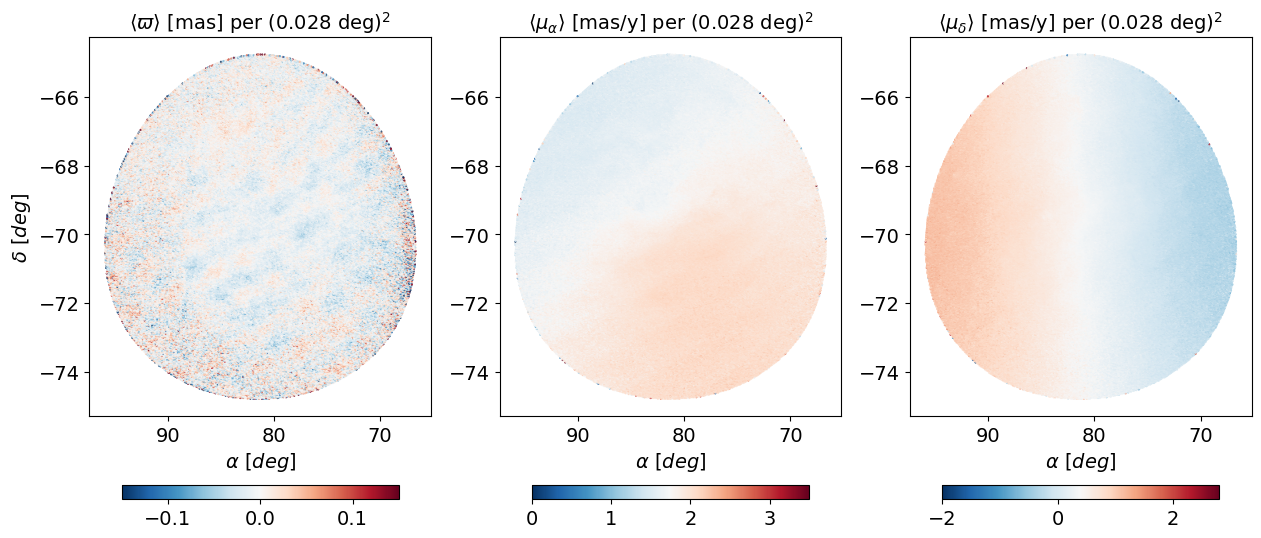

In [33]:
fig, ax = plt.subplots(1, 3,figsize=(15,6))
colormap = 'RdBu_r'
normalize = colors.Normalize(vmin=-0.15, vmax=0.15)
image = ax[0].scatter(coord[0], coord[1], s=0.2, alpha=1, c=parallax_field, cmap=colormap, norm=normalize)
cbar = fig.colorbar(image, ax=ax[0], orientation="horizontal", fraction=0.03);
ax[0].invert_xaxis()
ax[0].set_xlabel(r'$\alpha\ [deg]$'); ax[0].set_ylabel(r'$\delta\ [deg]$')
ax[0].set_title(r'$\langle \varpi\rangle\ [\mathrm{mas}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

normalize = colors.Normalize(vmin=0, vmax=3.5)
image = ax[1].scatter(coord[0], coord[1], s=0.2, alpha=1, c=pmra_field, cmap=colormap, norm=normalize)
ax[1].invert_xaxis()
ax[1].set_xlabel(r'$\alpha\ [deg]$'); 
cbar = fig.colorbar(image, ax=ax[1], orientation="horizontal",fraction=0.03);
ax[1].set_title(r'$\langle \mu_\alpha\rangle\ [\mathrm{mas/y}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

normalize = colors.Normalize(vmin=-2, vmax=2.8)
image = ax[2].scatter(coord[0], coord[1], s=0.2, alpha=1, c=pmdec_field, cmap=colormap, norm=normalize)
ax[2].invert_xaxis()
ax[2].set_xlabel(r'$\alpha\ [deg]$'); 
cbar = fig.colorbar(image, ax=ax[2], orientation="horizontal",fraction=0.03);
ax[2].set_title(r'$\langle \mu_\delta\rangle\ [\mathrm{mas/y}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

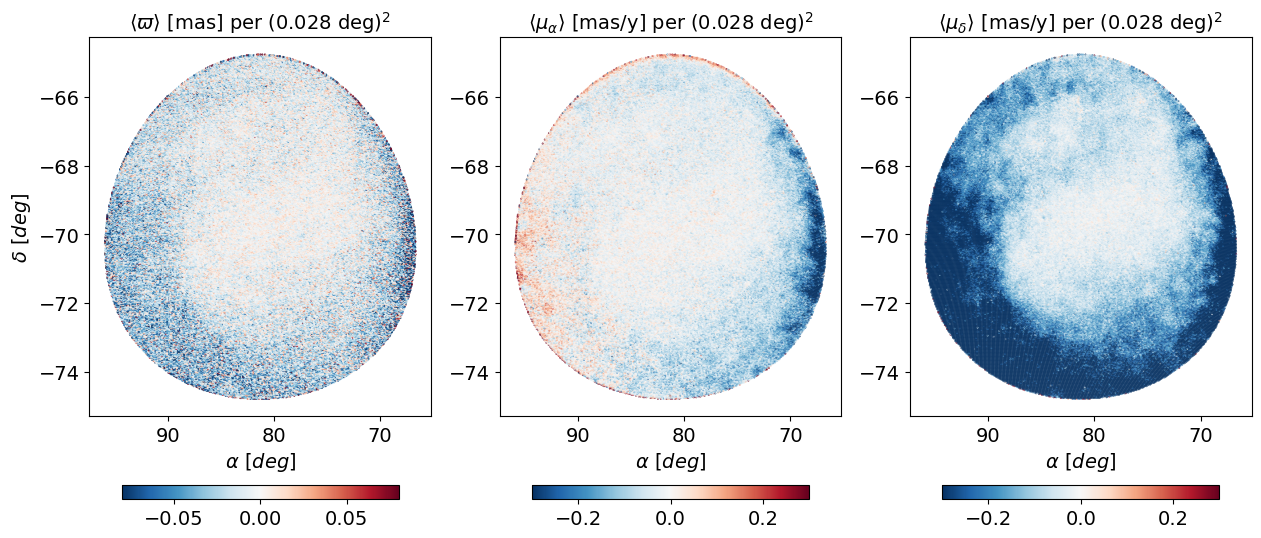

In [34]:
fig, ax = plt.subplots(1, 3,figsize=(15,6))
colormap = 'RdBu_r'
normalize = colors.Normalize(vmin=-0.08, vmax=0.08)
image = ax[0].scatter(coord[0], coord[1], s=0.2, alpha=1, c=parallax_field_sub, cmap=colormap, norm=normalize)
cbar = fig.colorbar(image, ax=ax[0], orientation="horizontal", fraction=0.03);
ax[0].invert_xaxis()
ax[0].set_xlabel(r'$\alpha\ [deg]$'); ax[0].set_ylabel(r'$\delta\ [deg]$')
ax[0].set_title(r'$\langle \varpi\rangle\ [\mathrm{mas}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

normalize = colors.Normalize(vmin=-0.3, vmax=0.3)
image = ax[1].scatter(coord[0], coord[1], s=0.1, alpha=1, c=pmra_field_sub, cmap=colormap, norm=normalize)
ax[1].invert_xaxis()
ax[1].set_xlabel(r'$\alpha\ [deg]$'); 
cbar = fig.colorbar(image, ax=ax[1], orientation="horizontal",fraction=0.03);
ax[1].set_title(r'$\langle \mu_\alpha\rangle\ [\mathrm{mas/y}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

normalize = colors.Normalize(vmin=-0.3, vmax=0.3)
image = ax[2].scatter(coord[0], coord[1], s=0.1, alpha=1, c=pmdec_field_sub, cmap=colormap, norm=normalize)
ax[2].invert_xaxis()
ax[2].set_xlabel(r'$\alpha\ [deg]$'); 
cbar = fig.colorbar(image, ax=ax[2], orientation="horizontal",fraction=0.03);
ax[2].set_title(r'$\langle \mu_\delta\rangle\ [\mathrm{mas/y}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

## Iterative background subtraction

### Execution

In [43]:
data = pd.read_csv(DataDir+'LMC_disc_5_clean.csv')  
data.shape

(14350220, 16)

In [35]:
### Pixelation for background subtraction
print('Background subtraction at scale', beta_kernel_sub/degree, 'degree')
n = round(math.log(np.sqrt(np.pi/3)/(beta_kernel_sub/3), 2))  # 11; pixelation scale at approx 1/3 of beta_kernel
nside = 2**n; npix = hp.nside2npix(nside);
print('nside =',nside,', npix =',npix)
print('linear pixel size =',str(np.sqrt(4*np.pi / npix) / arcsec)[0:7],' arcsec =', str(np.sqrt(4*np.pi / npix) / degree)[0:7],' degree')
vec = hp.pix2vec(nside, hp.ang2pix(nside, disc_center[0], disc_center[1], nest=True, lonlat=True), nest=True)
disc_pix = hp.query_disc(nside, vec, disc_radius, nest=True, inclusive=True) # pixels on the sky within the selected disc
print('number of pixels in the disc =', len(disc_pix))

Background subtraction at scale 0.05999999999999999 degree
nside = 4096 , npix = 201326592
linear pixel size = 51.5322  arcsec = 0.01431  degree
number of pixels in the disc = 384816


In [36]:
### Stars healpy pixel number
q_pix = np.asarray(hp.ang2pix(nside, data['ra'].to_numpy(), data['dec'].to_numpy(), nest=True, lonlat=True)) # healpy pixel number of the stars
data['q_pix_{}'.format(n)] = q_pix

In [37]:
### Find neighboring pixels for each pixel
radius_nb = 3*beta_kernel_sub;
#nb_pixel_array = fn_nb_pixel(disc_pix, radius_nb, nside, nest=True)
#len(nb_pixel_array), len(nb_pixel_array[0]), len(nb_pixel_array[55])
nb_pixel_list = fn_nb_pixel(disc_pix, radius_nb, nside, nest=True)
len(nb_pixel_list), len(nb_pixel_list[0]), len(nb_pixel_list[55])

(384816, 563, 560)

In [38]:
### Iterative background subtraction and outlier removal

#f_out = 1; i=0;
#while (i<n_iter_sub) & (f_out>f_out_min):
for i in range(n_iter_sub):
    fn_back_field_sub(data, disc_pix, nb_pixel_list, n, beta_kernel=beta_kernel_sub, sub=True) ### sub=True can be used only after this function has been already called once with sub=False
    data, f_out = fn_rem_outliers(data, pm_esc, D_s, n_sigma_out)
    print('Iter '+str(i)+' -- fraction of outliers removed: '+str(f_out*100)[:7]+' %')
    
fn_back_field_sub(data, disc_pix, nb_pixel_list, n, beta_kernel=beta_kernel_sub, sub=True)
data.shape

100%|██████████| 384816/384816 [02:18<00:00, 2772.84it/s]


Iter 0 -- fraction of outliers removed: 6.23526 %


100%|██████████| 384816/384816 [02:17<00:00, 2789.48it/s]


Iter 1 -- fraction of outliers removed: 0.01705 %


100%|██████████| 384816/384816 [02:19<00:00, 2758.83it/s]


Iter 2 -- fraction of outliers removed: 0.00661 %


100%|██████████| 384816/384816 [02:20<00:00, 2730.46it/s]


(13806743, 23)

In [41]:
### Iterative background subtraction and outlier removal

#f_out = 1; i=0;
#while (i<n_iter_sub) & (f_out>f_out_min):
for i in range(n_iter_sub):
    fn_back_field_sub(data, disc_pix, nb_pixel_list, n, beta_kernel=beta_kernel_sub)
    data, f_out = fn_rem_outliers(data, pm_esc, D_s, n_sigma_out)
    print('Iter '+str(i)+' -- fraction of outliers removed: '+str(f_out*100)[:7]+' %')
    
fn_back_field_sub(data, disc_pix, nb_pixel_list, n, beta_kernel=beta_kernel_sub)
data.shape

100%|██████████| 96630/96630 [00:25<00:00, 3865.03it/s]


Iter 0 -- fraction of outliers removed: 6.23934 %


100%|██████████| 96630/96630 [00:25<00:00, 3843.94it/s]


Iter 1 -- fraction of outliers removed: 0.01198 %


100%|██████████| 96630/96630 [00:25<00:00, 3795.73it/s]


Iter 2 -- fraction of outliers removed: 0.00070 %


100%|██████████| 96630/96630 [00:25<00:00, 3826.95it/s]


(13807658, 22)

In [39]:
### Remove stars at the boundary to avoid edge effect due to gaussian kernel field subtraction
data = fn_rem_edges(data, disc_center, disc_radius, n_iter_sub+1, beta_kernel=beta_kernel_sub)
data.shape

(13193650, 23)

### Plots

In [40]:
### Pm and parallax fields before subtraction
pix_size, coord, pmra_field, pmdec_field, parallax_field = fn_motion_field(data, beta_pixel=0.03*degree, sub=False, eff=False)

### Pm and parallax fields after subtraction
pix_size, coord_sub, pmra_field_sub, pmdec_field_sub, parallax_field_sub = fn_motion_field(data, beta_pixel=0.03*degree, sub=True, eff=False)

print(np.mean(parallax_field), np.mean(pmra_field), np.mean(pmdec_field))
print(np.mean(parallax_field_sub), np.mean(pmra_field_sub), np.mean(pmdec_field_sub))

-0.004942603475442012 1.8214868064173777 0.3732677825041664
-0.0003137168386065599 0.0003348672321974546 -0.0002965340285365266


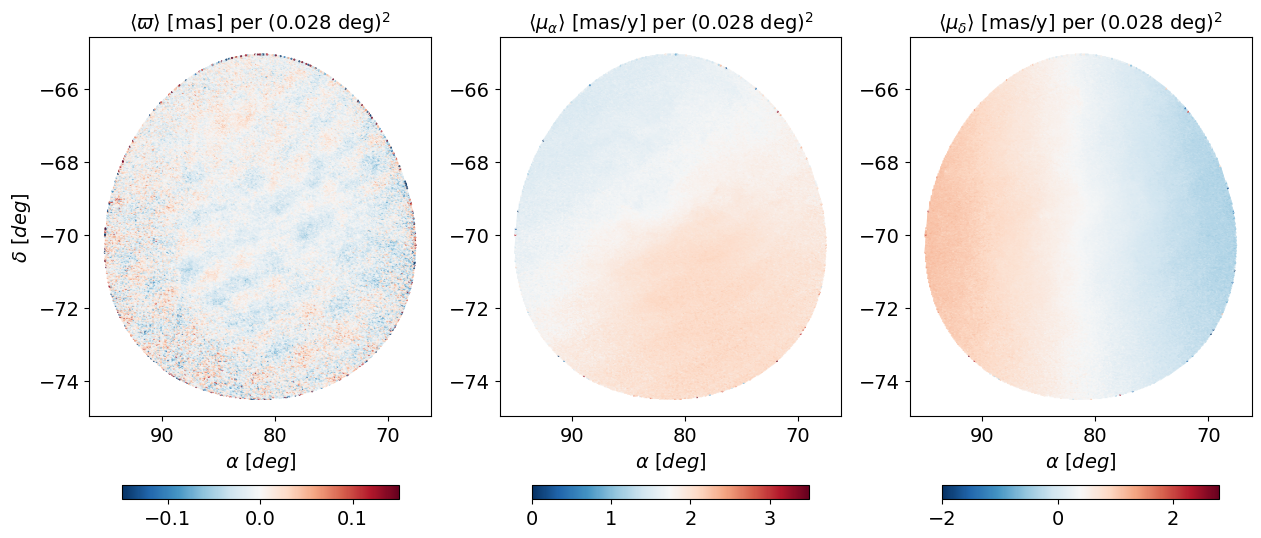

In [41]:
fig, ax = plt.subplots(1, 3,figsize=(15,6))
colormap = 'RdBu_r'
normalize = colors.Normalize(vmin=-0.15, vmax=0.15)
image = ax[0].scatter(coord[0], coord[1], s=0.2, alpha=1, c=parallax_field, cmap=colormap, norm=normalize)
cbar = fig.colorbar(image, ax=ax[0], orientation="horizontal", fraction=0.03);
ax[0].invert_xaxis()
ax[0].set_xlabel(r'$\alpha\ [deg]$'); ax[0].set_ylabel(r'$\delta\ [deg]$')
ax[0].set_title(r'$\langle \varpi\rangle\ [\mathrm{mas}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

normalize = colors.Normalize(vmin=0, vmax=3.5)
image = ax[1].scatter(coord[0], coord[1], s=0.2, alpha=1, c=pmra_field, cmap=colormap, norm=normalize)
ax[1].invert_xaxis()
ax[1].set_xlabel(r'$\alpha\ [deg]$'); 
cbar = fig.colorbar(image, ax=ax[1], orientation="horizontal",fraction=0.03);
ax[1].set_title(r'$\langle \mu_\alpha\rangle\ [\mathrm{mas/y}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

normalize = colors.Normalize(vmin=-2, vmax=2.8)
image = ax[2].scatter(coord[0], coord[1], s=0.2, alpha=1, c=pmdec_field, cmap=colormap, norm=normalize)
ax[2].invert_xaxis()
ax[2].set_xlabel(r'$\alpha\ [deg]$'); 
cbar = fig.colorbar(image, ax=ax[2], orientation="horizontal",fraction=0.03);
ax[2].set_title(r'$\langle \mu_\delta\rangle\ [\mathrm{mas/y}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

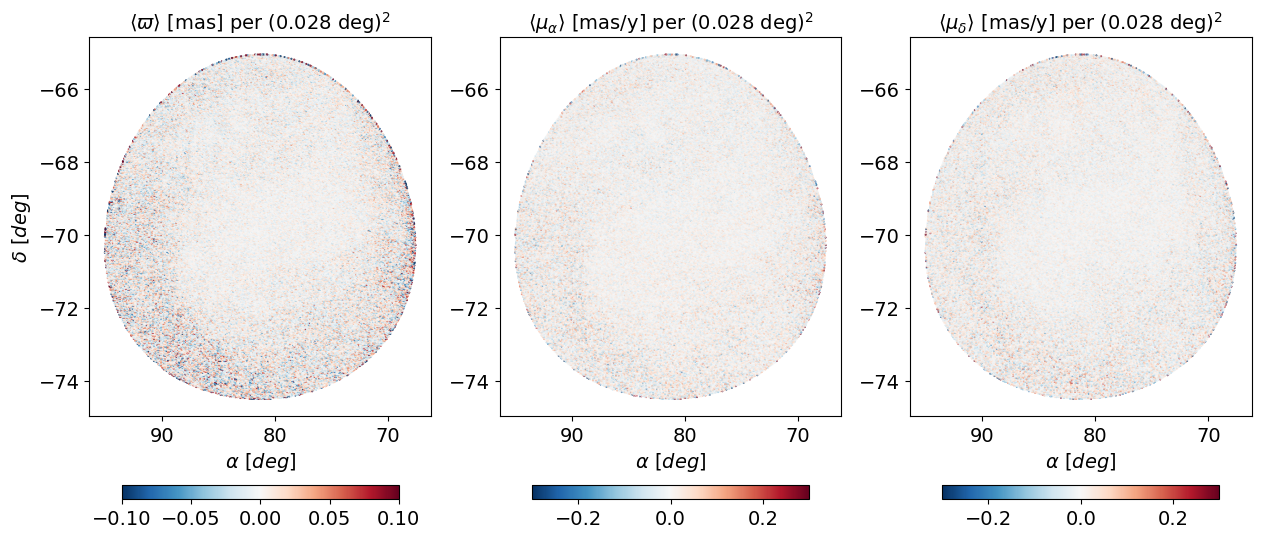

In [43]:
fig, ax = plt.subplots(1, 3,figsize=(15,6))
colormap = 'RdBu_r'
normalize = colors.Normalize(vmin=-0.1, vmax=0.1)
image = ax[0].scatter(coord[0], coord[1], s=0.2, alpha=1, c=parallax_field_sub, cmap=colormap, norm=normalize)
cbar = fig.colorbar(image, ax=ax[0], orientation="horizontal", fraction=0.03);
ax[0].invert_xaxis()
ax[0].set_xlabel(r'$\alpha\ [deg]$'); ax[0].set_ylabel(r'$\delta\ [deg]$')
ax[0].set_title(r'$\langle \varpi\rangle\ [\mathrm{mas}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

normalize = colors.Normalize(vmin=-0.3, vmax=0.3)
image = ax[1].scatter(coord[0], coord[1], s=0.1, alpha=1, c=pmra_field_sub, cmap=colormap, norm=normalize)
ax[1].invert_xaxis()
ax[1].set_xlabel(r'$\alpha\ [deg]$'); 
cbar = fig.colorbar(image, ax=ax[1], orientation="horizontal",fraction=0.03);
ax[1].set_title(r'$\langle \mu_\alpha\rangle\ [\mathrm{mas/y}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);
#ax[1].scatter(clumps_1[0], clumps_1[1], s=20, alpha=0.5, facecolors='none', edgecolors='k')
#ax[1].scatter(clumps_2[0], clumps_2[1], s=20, alpha=0.5, facecolors='none', edgecolors='b')

normalize = colors.Normalize(vmin=-0.3, vmax=0.3)
image = ax[2].scatter(coord[0], coord[1], s=0.1, alpha=1, c=pmdec_field_sub, cmap=colormap, norm=normalize)
ax[2].invert_xaxis()
ax[2].set_xlabel(r'$\alpha\ [deg]$'); 
cbar = fig.colorbar(image, ax=ax[2], orientation="horizontal",fraction=0.03);
ax[2].set_title(r'$\langle \mu_\delta\rangle\ [\mathrm{mas/y}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

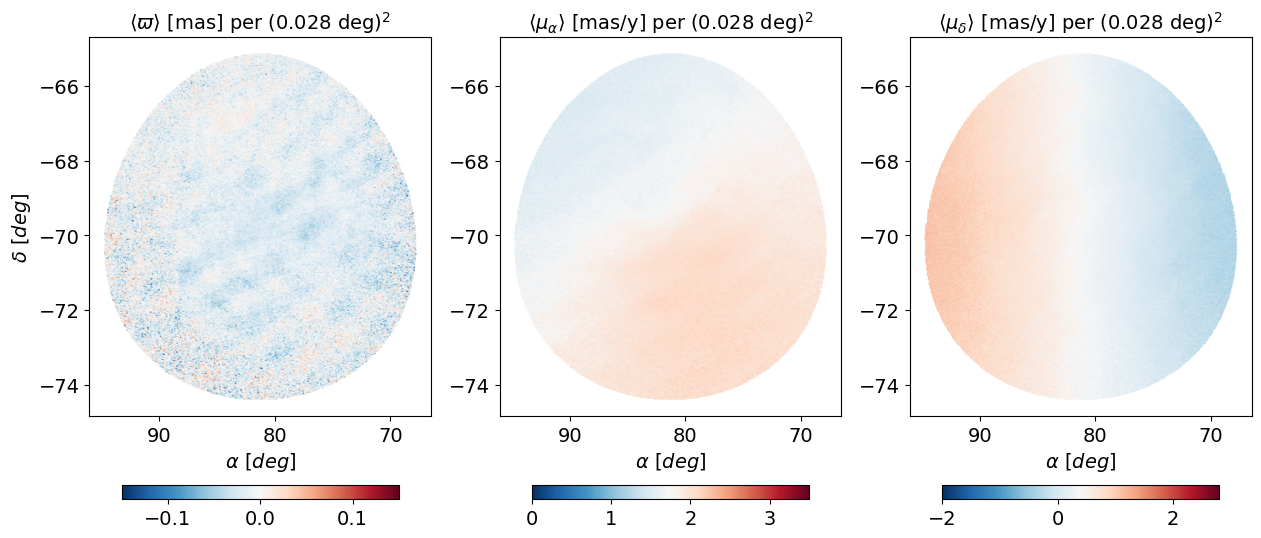

In [31]:
fig, ax = plt.subplots(1, 3,figsize=(15,6))
colormap = 'RdBu_r'
normalize = colors.Normalize(vmin=-0.15, vmax=0.15)
image = ax[0].scatter(coord[0], coord[1], s=0.2, alpha=1, c=parallax_field, cmap=colormap, norm=normalize)
cbar = fig.colorbar(image, ax=ax[0], orientation="horizontal", fraction=0.03);
ax[0].invert_xaxis()
ax[0].set_xlabel(r'$\alpha\ [deg]$'); ax[0].set_ylabel(r'$\delta\ [deg]$')
ax[0].set_title(r'$\langle \varpi\rangle\ [\mathrm{mas}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

normalize = colors.Normalize(vmin=0, vmax=3.5)
image = ax[1].scatter(coord[0], coord[1], s=0.2, alpha=1, c=pmra_field, cmap=colormap, norm=normalize)
ax[1].invert_xaxis()
ax[1].set_xlabel(r'$\alpha\ [deg]$'); 
cbar = fig.colorbar(image, ax=ax[1], orientation="horizontal",fraction=0.03);
ax[1].set_title(r'$\langle \mu_\alpha\rangle\ [\mathrm{mas/y}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

normalize = colors.Normalize(vmin=-2, vmax=2.8)
image = ax[2].scatter(coord[0], coord[1], s=0.2, alpha=1, c=pmdec_field, cmap=colormap, norm=normalize)
ax[2].invert_xaxis()
ax[2].set_xlabel(r'$\alpha\ [deg]$'); 
cbar = fig.colorbar(image, ax=ax[2], orientation="horizontal",fraction=0.03);
ax[2].set_title(r'$\langle \mu_\delta\rangle\ [\mathrm{mas/y}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

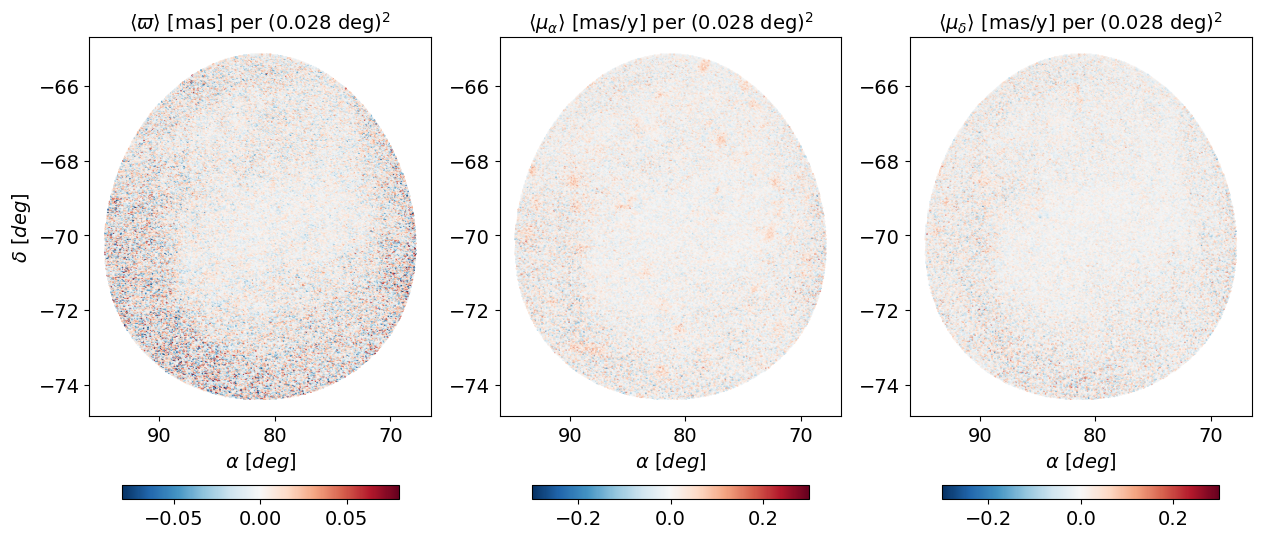

In [32]:
fig, ax = plt.subplots(1, 3,figsize=(15,6))
colormap = 'RdBu_r'
normalize = colors.Normalize(vmin=-0.08, vmax=0.08)
image = ax[0].scatter(coord[0], coord[1], s=0.2, alpha=1, c=parallax_field_sub, cmap=colormap, norm=normalize)
cbar = fig.colorbar(image, ax=ax[0], orientation="horizontal", fraction=0.03);
ax[0].invert_xaxis()
ax[0].set_xlabel(r'$\alpha\ [deg]$'); ax[0].set_ylabel(r'$\delta\ [deg]$')
ax[0].set_title(r'$\langle \varpi\rangle\ [\mathrm{mas}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

normalize = colors.Normalize(vmin=-0.3, vmax=0.3)
image = ax[1].scatter(coord[0], coord[1], s=0.1, alpha=1, c=pmra_field_sub, cmap=colormap, norm=normalize)
ax[1].invert_xaxis()
ax[1].set_xlabel(r'$\alpha\ [deg]$'); 
cbar = fig.colorbar(image, ax=ax[1], orientation="horizontal",fraction=0.03);
ax[1].set_title(r'$\langle \mu_\alpha\rangle\ [\mathrm{mas/y}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

normalize = colors.Normalize(vmin=-0.3, vmax=0.3)
image = ax[2].scatter(coord[0], coord[1], s=0.1, alpha=1, c=pmdec_field_sub, cmap=colormap, norm=normalize)
ax[2].invert_xaxis()
ax[2].set_xlabel(r'$\alpha\ [deg]$'); 
cbar = fig.colorbar(image, ax=ax[2], orientation="horizontal",fraction=0.03);
ax[2].set_title(r'$\langle \mu_\delta\rangle\ [\mathrm{mas/y}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);

## Effective weights

In [44]:
fn_effective_w(data, disc_center, gmag_bin_size=0.1, rad_bin_size=1)
data.shape

(13193650, 25)

In [45]:
### Export the final processed data for the template scan - saving to a npy file makes it much faster to upload
#data[['ra', 'dec', 'pmra_sub', 'pmdec_sub', 'parallax_sub', 'pm_eff_error', 'parallax_eff_error']].to_csv(DataDir+'LMC_disc_5_final.csv', index=False)
### Quantities used to compute the template
pm_w_sq = (data['pm_eff_error'].to_numpy())**2
weighted_pmra = data['pmra_sub'].to_numpy()/data['pm_eff_error'].to_numpy()**2
weighted_pmdec = data['pmdec_sub'].to_numpy()/data['pm_eff_error'].to_numpy()**2
par_w_sq = (data['parallax_eff_error'].to_numpy())**2
weighted_par = data['parallax_sub'].to_numpy()/data['parallax_eff_error'].to_numpy()**2

np.save(DataDir+'LMC_disc_5_final', np.array([data['ra'].to_numpy(), data['dec'].to_numpy(), data['ecl_lon'].to_numpy(), data['ecl_lat'].to_numpy(), pm_w_sq, weighted_pmra, weighted_pmdec, par_w_sq, weighted_par]).T)

### Plots

In [96]:
bins_g, counts, hist_pm_disp, hist_par_disp = fn_effective_err(data, disc_center, gmag_bin_size=0.2)
bins_g, hist_pm_err, hist_par_err, hist_pm_eff_err, hist_par_eff_err = fn_avg_err(data, disc_center, gmag_bin_size=0.2)

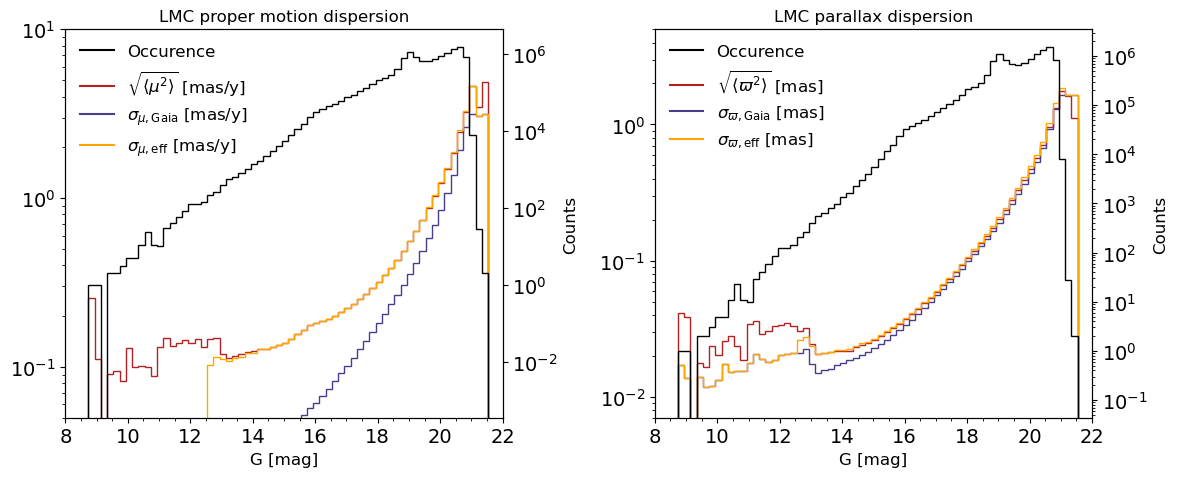

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
colorlist = ['firebrick', 'darkslateblue', 'orange']
bottomy = 0.05

ax[0].minorticks_on()
ax[0].hist(bins_g[:-1], weights=hist_pm_disp, bins=bins_g, log=True, histtype='step', linewidth=1, color=colorlist[0]);
ax[0].hist(bins_g[:-1], weights=hist_pm_err, bins=bins_g, log=True, histtype='step', linewidth=1, color=colorlist[1]);
ax[0].hist(bins_g[:-1], weights=hist_pm_eff_err, bins=bins_g, log=True, histtype='step', linewidth=1, color=colorlist[2]);

ax2 = ax[0].twinx()
ax2.hist(bins_g[:-1], weights=counts, bins=bins_g, log=True, histtype='step', linewidth=1, color='k');

ax2.set_ylabel(r'Counts', fontsize = 12);
p = [plt.plot([bins_g[0], bins_g[1]], [10, 0.2], linewidth=1.5, color='k')[0],
     plt.plot([bins_g[0], bins_g[1]], [0.1, 0.2], linewidth=1.5, color=colorlist[0])[0],
     plt.plot([bins_g[0], bins_g[1]], [0.1, 0.2], linewidth=1.5, color=colorlist[1])[0],
     plt.plot([bins_g[0], bins_g[1]], [0.001, 0.002], linewidth=1.5, color=colorlist[2])[0]] # for the intrinsic dispersion

ax[0].legend(p, [r'Occurence', r'$\sqrt{\langle \mu^2 \rangle}$ [mas/y]', r'$\sigma_{\mu, \mathrm{Gaia}}$ [mas/y]', r'$\sigma_{\mu, \mathrm{eff}}$ [mas/y]'], 
               loc='upper left', fontsize = 12, frameon=False);
p[0].set_visible(False); p[1].set_visible(False); p[2].set_visible(False); p[3].set_visible(False)
ax[0].set_xlabel('G [mag]', fontsize = 12);
ax[0].set_xlim(8,22);
ax[0].set_ylim(bottomy,10);
ax[0].set_title('LMC proper motion dispersion', fontsize = 12)

bottomy = 0.007
ax[1].minorticks_on()
ax[1].hist(bins_g[:-1], weights=hist_par_disp, bins=bins_g, log=True, histtype='step', linewidth=1, color=colorlist[0]);
ax[1].hist(bins_g[:-1], weights=hist_par_err, bins=bins_g, log=True, histtype='step', linewidth=1, color=colorlist[1]);
ax[1].hist(bins_g[:-1], weights=hist_par_eff_err, bins=bins_g, log=True, histtype='step', linewidth=1, color=colorlist[2]);

ax2 = ax[1].twinx()
ax2.hist(bins_g[:-1], weights=counts, bins=bins_g, log=True, histtype='step', linewidth=1, color='k');

ax2.set_ylabel(r'Counts', fontsize = 12);
p = [plt.plot([bins_g[0], bins_g[1]], [0.1, 0.2], linewidth=1.5, color='k')[0],
     plt.plot([bins_g[0], bins_g[1]], [0.1, 0.2], linewidth=1.5, color=colorlist[0])[0],
     plt.plot([bins_g[0], bins_g[1]], [0.1, 0.2], linewidth=1.5, color=colorlist[1])[0],
     plt.plot([bins_g[0], bins_g[1]], [0.1, 0.2], linewidth=1.5, color=colorlist[2])[0]] # for the intrinsic dispersion

ax[1].legend(p, [r'Occurence', r'$\sqrt{\langle \varpi^2 \rangle}$ [mas]', r'$\sigma_{\varpi, \mathrm{Gaia}}$ [mas]', r'$\sigma_{\varpi, \mathrm{eff}}$ [mas]'], 
               loc='upper left', fontsize = 12, frameon=False);
p[0].set_visible(False); p[1].set_visible(False); p[2].set_visible(False); p[3].set_visible(False)
ax[1].set_xlabel('G [mag]', fontsize = 12);
ax[1].set_xlim(8,22);
ax[1].set_ylim(bottomy,5);
ax[1].set_title('LMC parallax dispersion', fontsize = 12)

fig.tight_layout()
#fig.savefig(FigDir+'draft/pmdispersionLMC.pdf')

## Template scan 

In [46]:
data_np = np.load(DataDir+'LMC_disc_5_final.npy') ### Much faster than reading in a csv file
### Columns of the numpy array are are: 
### [data['ra'].to_numpy(), data['dec'].to_numpy(), data['pm_eff_error'].to_numpy()**2, data['pmra_sub'].to_numpy()/data['pm_eff_error'].to_numpy()**2, data['pmdec_sub'].to_numpy()/data['pm_eff_error'].to_numpy()**2, 
###  data['parallax_eff_error'].to_numpy()**2, data['parallax_sub'].to_numpy()/data['parallax_eff_error'].to_numpy()**2]
[data_ra, data_dec, data_ecl_lon, data_ecl_lat, pm_w_sq, weighted_pmra, weighted_pmdec, par_w_sq, weighted_par] = data_np.T
del data_np

In [54]:
### check the equatorial to ecliptic coordinate transformation
#test_l, test_b  = fn_eq_to_ecl_array(data_ra, data_dec)
#aa = test_b/data_ecl_lat
#aa[np.abs(aa-1) > 1E-8]

In [47]:
n_betat = 3.5;
beta_t_deg = str(300)
beta_t = float(beta_t_deg)/10000*degree

In [48]:
### Coarse pixelation of size approx. beta_t. Determine how many template scan location there are
n = math.ceil(math.log(np.sqrt(np.pi/3)/beta_t, 2)); nside = 2**n; 
vec = hp.pix2vec(nside, hp.ang2pix(nside, disc_center[0], disc_center[1], nest=True, lonlat=True), nest=True)
disc_pix_coarse = hp.query_disc(nside, vec, disc_radius - beta_kernel_sub_0 - (n_iter_sub+1)*beta_kernel_sub - n_betat*beta_t, nest=True, inclusive=False) # pixels on the sky within a disc without the edge
n_locations = len(disc_pix_coarse)

print('Template scan for beta_t = '+str(beta_t/degree)+' deg.')
print('Number of template locations: '+str(n_locations))

Template scan for beta_t = 0.029999999999999995 deg.
Number of template locations: 79494


In [49]:
coarse_scan_coord = hp.pix2ang(nside, disc_pix_coarse, nest=True, lonlat=True) # to be converted into pixels at the fine pixelation scale below
coarse_scan_coord_ecl = fn_eq_to_ecl_array(coarse_scan_coord[0], coarse_scan_coord[1]) # convert into ecliptic coordinates for the parallax template

In [50]:
### Fine pixelation of size approx. beta_t/10 (can be a bit larger than beta_t/10, so using round is fine)
n = round(math.log(np.sqrt(np.pi/3)/(0.1*beta_t), 2)); nside = 2**n; 
vec = hp.pix2vec(nside, hp.ang2pix(nside, disc_center[0], disc_center[1], nest=True, lonlat=True), nest=True)
coarse_scan_pix = hp.ang2pix(nside, coarse_scan_coord[0], coarse_scan_coord[1], nest=True, lonlat=True)            

q_pix = np.asarray(hp.ang2pix(nside, data_ra, data_dec, nest=True, lonlat=True)) # healpy pixel number of the stars, needed to find stars near a specific template location

In [51]:
### Compute the template for "step" number of location
i_step=0

print('Starting the template scan...')

tic = tictoc()
fn_template_scan(nside, coarse_scan_pix)
toc = tictoc()    

print('Template scan completed in', str(toc - tic), 's.')

  0%|          | 0/79494 [00:00<?, ?it/s]

Starting the template scan...


100%|██████████| 79494/79494 [15:33:51<00:00,  1.42it/s]      

Template scan completed in 56031.248909950256 s.


# Results from coarse template scan

In [5]:
beta_t_deg = str(90)
beta_t = float(beta_t_deg)/10000*degree

In [6]:
list_files = os.listdir(ListTauDir)
list_files = [file for file in list_files if file[5:6+len(beta_t_deg)]==beta_t_deg+'_'] #select only files corresponding to the correct beta_t
if len(list_files) < 1:
    print('ERROR: cannot find any file for the selected beta_t value of '+str(beta_t/degree)+' deg.')
    sys.stdout.flush()
    sys.exit()
print(str(len(list_files))+' files found for beta_t value of '+str(beta_t/degree)+' deg.')

40 files found for beta_t value of 0.009 deg.


## Tau histograms

In [10]:
[ind_ra, ind_dec, ind_tau_ra, ind_tau_dec, ind_n, ind_tau_mon, ind_tau_mon_n, ind_tau_par, ind_par_n] = range(9)

### Importe the values of Tau from the coarse scanning
tau_values = []
for file in list_files:
    tau_values.extend(np.load(ListTauDir+file))
    
tau_values = np.array(tau_values)
tau_values.shape

(1313115, 9)

In [70]:
#[ind_ra, ind_dec, ind_tau_ra, ind_tau_dec, ind_n, ind_tau_par, ind_par_n] = range(9)

### Importe the values of Tau from the coarse scanning
tau_values = []
for file in list_files:
    tau_values.extend(np.load('../lists/coarse_tau/old/'+file))
    
tau_values = np.array(tau_values)
tau_values.shape

(639680, 5)

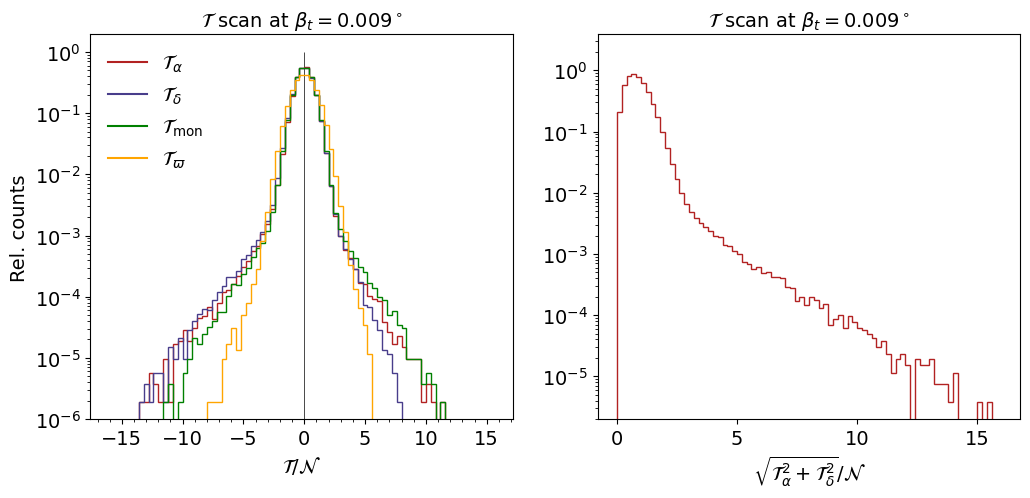

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
colorlist = ['firebrick', 'darkslateblue', 'green', 'orange']
xmin, xmax, nbins = -16, 16, 80
bins = np.arange(xmin,xmax, (xmax-xmin)/nbins)

ax[0].minorticks_on()
ax[0].hist(tau_values[:,ind_tau_ra]/tau_values[:,ind_n], bins=bins, histtype='step',log=True, density=True, linewidth=1, color=colorlist[0]);
ax[0].hist(tau_values[:,ind_tau_dec]/tau_values[:,ind_n], bins=bins, histtype='step',log=True, density=True, linewidth=1, color=colorlist[1]);
ax[0].hist(tau_values[:,ind_tau_mon]/tau_values[:,ind_tau_mon_n], bins=bins, histtype='step',log=True, density=True, linewidth=1, color=colorlist[2]);
ax[0].hist(tau_values[:,ind_tau_par]/tau_values[:,ind_par_n], bins=bins, histtype='step',log=True, density=True, linewidth=1, color=colorlist[3]);
ax[0].vlines(0, 0, 1, colors='k', linestyles='solid', label='', linewidth=0.5)
ax[0].set_xlabel(r'$\mathcal{T}/\mathcal{N}$'); ax[0].set_ylabel(r'Rel. counts'); 
ax[0].set_title(r'$\mathcal{T}$ scan at $\beta_t = 0.009^\circ$', fontsize=14);

p = [plt.plot([0, xmax], [2, 2], linewidth=1.5, color=colorlist[i])[0] for i in range(len(colorlist))]
ax[0].legend(p, [r'$\mathcal{T}_{\alpha}$', r'$\mathcal{T}_{\delta}$', r'$\mathcal{T}_{\mathrm{mon}}$', 
                 r'$\mathcal{T}_{\varpi}$'], loc='upper left', fontsize = 14, frameon=False);
[p[i].set_visible(False) for i in range(len(p))]

xmin, xmax, nbins = 0, 16, 80
bins = np.arange(xmin,xmax, (xmax-xmin)/nbins)
ax[1].hist(np.sqrt(tau_values[:,ind_tau_ra]**2 + tau_values[:,ind_tau_dec]**2)/tau_values[:,ind_n], bins=bins, histtype='step',log=True, density=True, linewidth=1, color=colorlist[0]);
ax[1].set_xlabel(r'$\sqrt{\mathcal{T}_{\alpha}^2 + \mathcal{T}_{\delta}^2}/\mathcal{N}$');
ax[1].set_title(r'$\mathcal{T}$ scan at $\beta_t = 0.009^\circ$', fontsize=14);

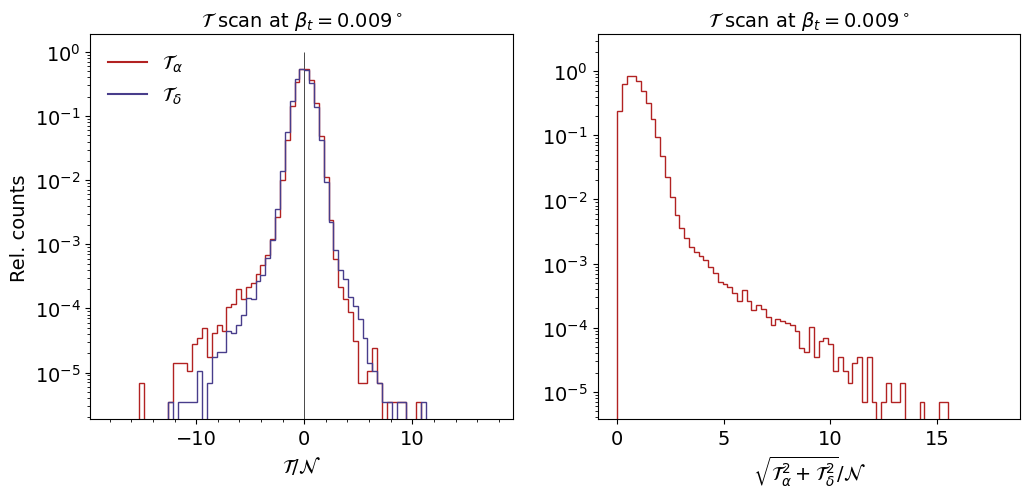

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
colorlist = ['firebrick', 'darkslateblue']
xmin, xmax, nbins = -18, 18, 80
bins = np.arange(xmin,xmax, (xmax-xmin)/nbins)

ax[0].minorticks_on()
ax[0].hist(tau_values[:,ind_tau_ra]/tau_values[:,ind_n], bins=bins, histtype='step',log=True, density=True, linewidth=1, color=colorlist[0]);
ax[0].hist(tau_values[:,ind_tau_dec]/tau_values[:,ind_n], bins=bins, histtype='step',log=True, density=True, linewidth=1, color=colorlist[1]);
ax[0].vlines(0, 0, 1, colors='k', linestyles='solid', label='', linewidth=0.5)
ax[0].set_xlabel(r'$\mathcal{T}/\mathcal{N}$'); ax[0].set_ylabel(r'Rel. counts'); 
ax[0].set_title(r'$\mathcal{T}$ scan at $\beta_t = 0.009^\circ$', fontsize=14);

p = [plt.plot([0, xmax], [2, 2], linewidth=1.5, color=colorlist[i])[0] for i in range(len(colorlist))]
ax[0].legend(p, [r'$\mathcal{T}_{\alpha}$', r'$\mathcal{T}_{\delta}$', r'$\mathcal{T}_{\mathrm{mon}}$', 
                 r'$\mathcal{T}_{\varpi}$'], loc='upper left', fontsize = 14, frameon=False);
[p[i].set_visible(False) for i in range(len(p))]

xmin, xmax, nbins = 0, 18, 80
bins = np.arange(xmin,xmax, (xmax-xmin)/nbins)
ax[1].hist(np.sqrt(tau_values[:,ind_tau_ra]**2 + tau_values[:,ind_tau_dec]**2)/tau_values[:,ind_n], bins=bins, histtype='step',log=True, density=True, linewidth=1, color=colorlist[0]);
ax[1].set_xlabel(r'$\sqrt{\mathcal{T}_{\alpha}^2 + \mathcal{T}_{\delta}^2}/\mathcal{N}$');
ax[1].set_title(r'$\mathcal{T}$ scan at $\beta_t = 0.009^\circ$', fontsize=14);

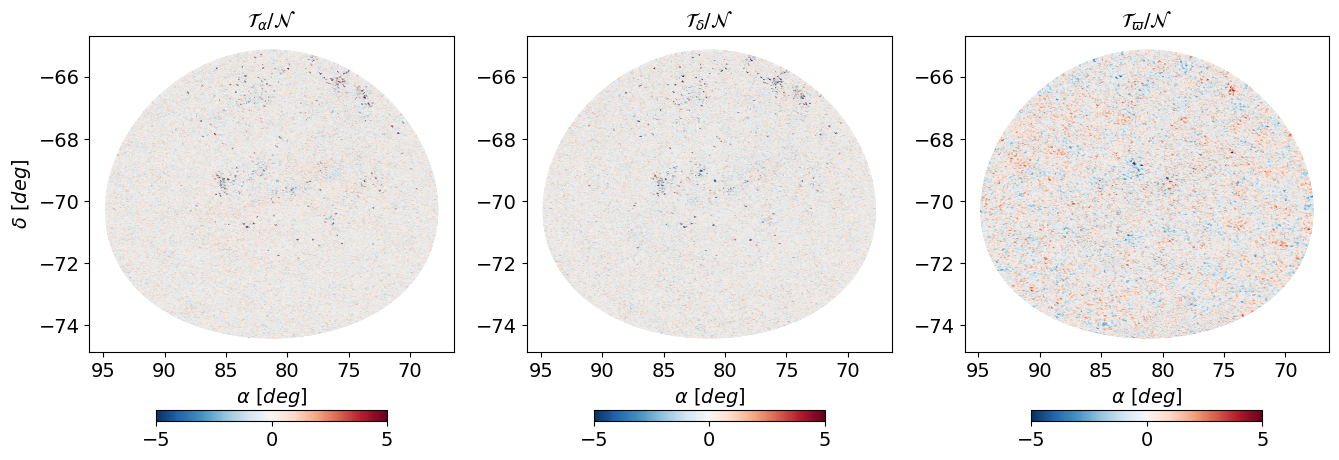

In [39]:
fig, ax = plt.subplots(1, 3,figsize=(16,5))
colormap = 'RdBu_r'
index = -1; point_size = 0.05

normalize = colors.Normalize(vmin=-5, vmax=5)
image = ax[0].scatter(tau_values[:index,ind_ra], tau_values[:index,ind_dec], s=point_size, alpha=1, c=tau_values[:index,ind_tau_ra]/tau_values[:index,ind_n], cmap=colormap, norm=normalize)
cbar = fig.colorbar(image, ax=ax[0], orientation="horizontal", fraction=0.03);
ax[0].invert_xaxis()
ax[0].set_xlabel(r'$\alpha\ [deg]$'); ax[0].set_ylabel(r'$\delta\ [deg]$')
ax[0].set_title(r'$\mathcal{T}_\alpha/\mathcal{N}$', fontsize=14);
#ax[0].scatter(clumps_1[0], clumps_1[1], s=20, alpha=0.5, facecolors='none', edgecolors='k')
#ax[0].scatter(clumps_2[0], clumps_2[1], s=20, alpha=0.5, facecolors='none', edgecolors='b')

image = ax[1].scatter(tau_values[:index,ind_ra], tau_values[:index,ind_dec], s=point_size, alpha=1, c=tau_values[:index,ind_tau_dec]/tau_values[:index,ind_n], cmap=colormap, norm=normalize)
cbar = fig.colorbar(image, ax=ax[1], orientation="horizontal", fraction=0.03);
ax[1].invert_xaxis()
ax[1].set_xlabel(r'$\alpha\ [deg]$');
ax[1].set_title(r'$\mathcal{T}_\delta/\mathcal{N}$', fontsize=14);
#ax[1].scatter(clumps_1[0], clumps_1[1], s=10, alpha=0.5, facecolors='none', edgecolors='k')
#ax[1].scatter(clumps_2[0], clumps_2[1], s=10, alpha=0.5, facecolors='none', edgecolors='b')

image = ax[2].scatter(tau_values[:index,ind_ra], tau_values[:index,ind_dec], s=point_size, alpha=1, c=tau_values[:index,ind_tau_par]/tau_values[:index,ind_par_n], cmap=colormap, norm=normalize)
cbar = fig.colorbar(image, ax=ax[2], orientation="horizontal", fraction=0.03);
#ax[2].scatter(clumps_1[0], clumps_1[1], s=10, alpha=0.5, facecolors='none', edgecolors='k')
#ax[2].scatter(clumps_2[0], clumps_2[1], s=10, alpha=0.5, facecolors='none', edgecolors='b')
ax[2].invert_xaxis()
ax[2].set_xlabel(r'$\alpha\ [deg]$'); 
ax[2].set_title(r'$\mathcal{T}_\varpi/\mathcal{N}$', fontsize=14);

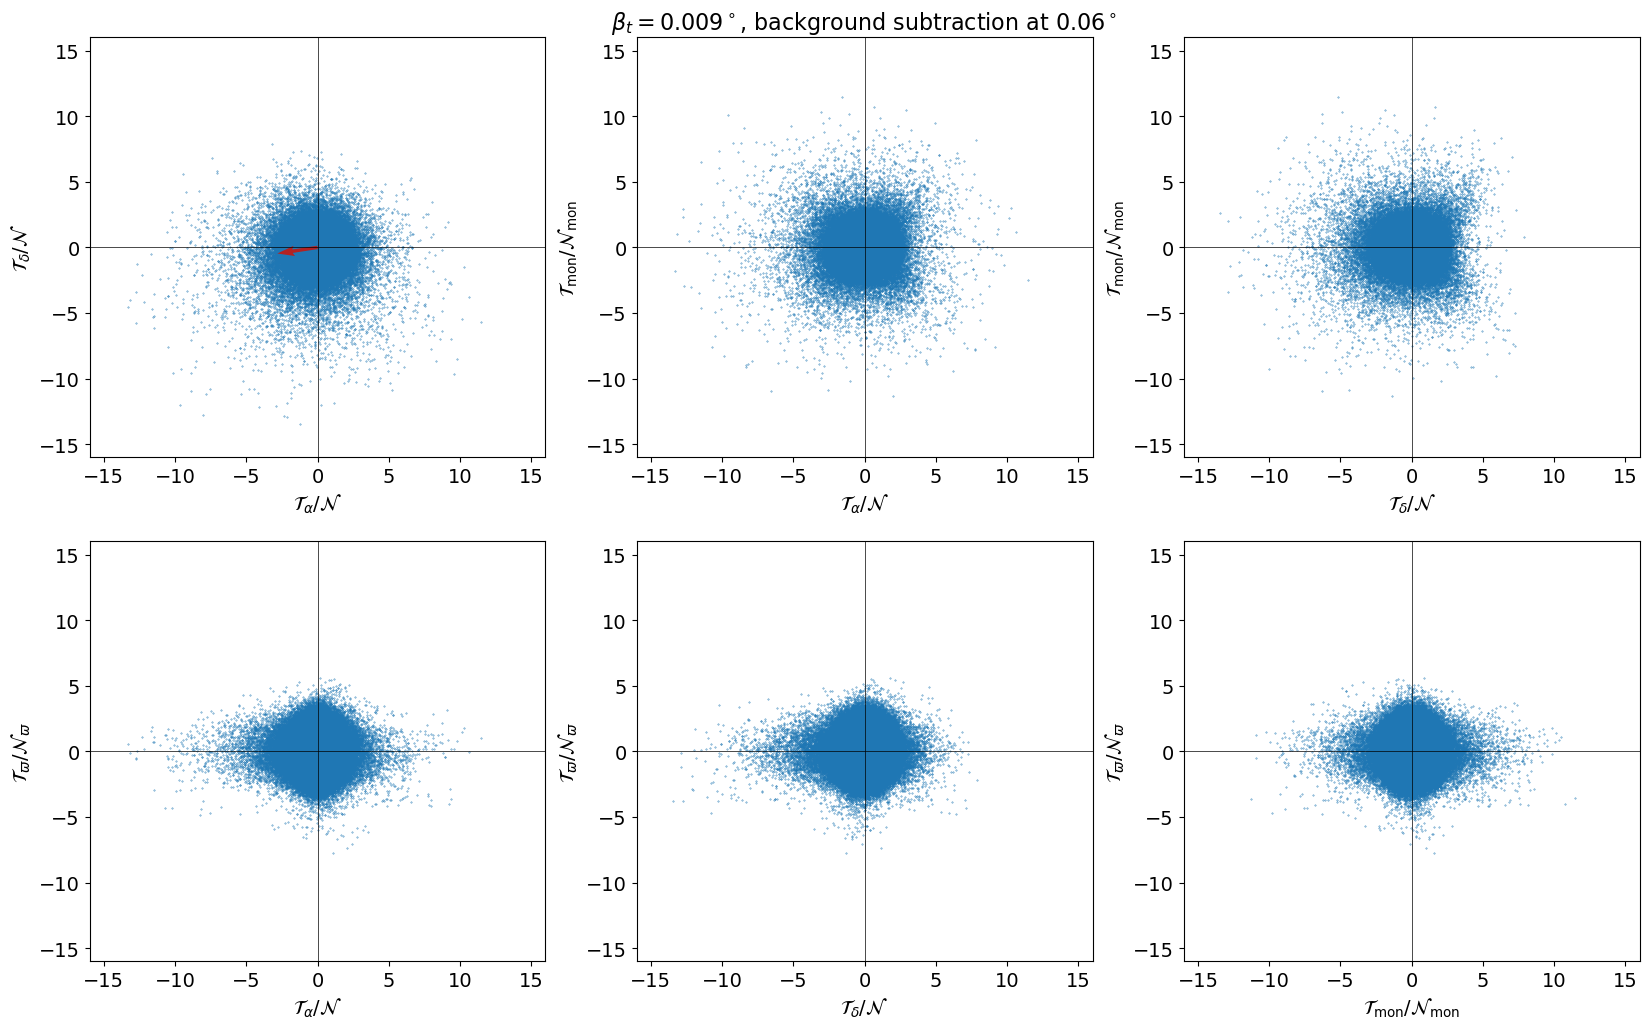

In [67]:
fig, ax = plt.subplots(2, 3,figsize=(20,12))
point_size = 0.1; xlim = 16
index = -1; 

v0_LMC = -np.array([4.41243874e-04, 6.68110714e-05]) # -v_observer

tau_ra_norm, tau_dec_norm = tau_values[:index,ind_tau_ra]/tau_values[:index,ind_n], tau_values[:index,ind_tau_dec]/tau_values[:index,ind_n]

ax[0][0].scatter(tau_ra_norm, tau_dec_norm, s=point_size, alpha=1)
ax[0][0].quiver(0, 0, v0_LMC[0], v0_LMC[1], color='firebrick', scale=0.005);
ax[0][0].set_xlabel(r'$\mathcal{T}_\alpha/\mathcal{N}$'); ax[0][0].set_ylabel(r'$\mathcal{T}_\delta/\mathcal{N}$')

ax[0][1].scatter(tau_ra_norm, tau_values[:index,ind_tau_mon]/tau_values[:index,ind_tau_mon_n], s=point_size, alpha=1)
ax[0][1].set_xlabel(r'$\mathcal{T}_\alpha/\mathcal{N}$'); ax[0][1].set_ylabel(r'$\mathcal{T}_\mathrm{mon}/\mathcal{N}_\mathrm{mon}$');
ax[0][1].set_title(r'$\beta_t = 0.009^\circ$, background subtraction at $0.06^\circ$', fontsize=16);

ax[0][2].scatter(tau_dec_norm, tau_values[:index,ind_tau_mon]/tau_values[:index,ind_tau_mon_n], s=point_size, alpha=1)
ax[0][2].set_xlabel(r'$\mathcal{T}_\delta/\mathcal{N}$'); ax[0][2].set_ylabel(r'$\mathcal{T}_\mathrm{mon}/\mathcal{N}_\mathrm{mon}$');

ax[1][0].scatter(tau_ra_norm, tau_values[:index,ind_tau_par]/tau_values[:index,ind_par_n], s=point_size, alpha=1)
ax[1][0].set_xlabel(r'$\mathcal{T}_\alpha/\mathcal{N}$'); ax[1][0].set_ylabel(r'$\mathcal{T}_\varpi/\mathcal{N}_\varpi$');

ax[1][1].scatter(tau_dec_norm, tau_values[:index,ind_tau_par]/tau_values[:index,ind_par_n], s=point_size, alpha=1)
ax[1][1].set_xlabel(r'$\mathcal{T}_\delta/\mathcal{N}$'); ax[1][1].set_ylabel(r'$\mathcal{T}_\varpi/\mathcal{N}_\varpi$');

ax[1][2].scatter(tau_values[:index,ind_tau_mon]/tau_values[:index,ind_tau_mon_n], tau_values[:index,ind_tau_par]/tau_values[:index,ind_par_n], s=point_size, alpha=1)
ax[1][2].set_xlabel(r'$\mathcal{T}_\mathrm{mon}/\mathcal{N}_\mathrm{mon}$'); ax[1][2].set_ylabel(r'$\mathcal{T}_\varpi/\mathcal{N}_\varpi$');

for i in range(len(ax)):
    for j in range(len(ax[i])):
        ax[i][j].vlines(0, -xlim, xlim, colors='k', linestyles='solid', label='', linewidth=0.5)
        ax[i][j].hlines(0, -xlim, xlim, colors='k', linestyles='solid', label='', linewidth=0.5)
        ax[i][j].set_xlim(-xlim,xlim); ax[i][j].set_ylim(-xlim,xlim)        

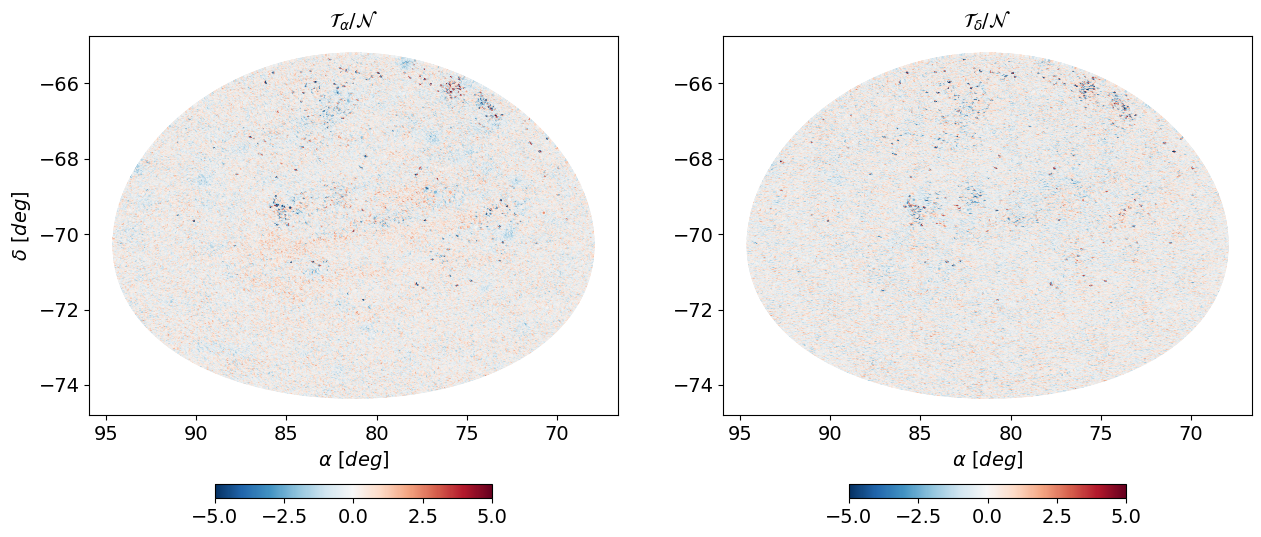

In [38]:
fig, ax = plt.subplots(1, 2,figsize=(14,6))
colormap = 'RdBu_r'
index = -1; point_size = 0.1

normalize = colors.Normalize(vmin=-5, vmax=5)
image = ax[0].scatter(tau_values[:index,ind_ra], tau_values[:index,ind_dec], s=point_size, alpha=1, c=tau_values[:index,ind_tau_ra]/tau_values[:index,ind_n], cmap=colormap, norm=normalize)
cbar = fig.colorbar(image, ax=ax[0], orientation="horizontal", fraction=0.03);
ax[0].invert_xaxis()
ax[0].set_xlabel(r'$\alpha\ [deg]$'); ax[0].set_ylabel(r'$\delta\ [deg]$')
ax[0].set_title(r'$\mathcal{T}_\alpha/\mathcal{N}$', fontsize=14);

image = ax[1].scatter(tau_values[:index,ind_ra], tau_values[:index,ind_dec], s=point_size, alpha=1, c=tau_values[:index,ind_tau_dec]/tau_values[:index,ind_n], cmap=colormap, norm=normalize)
cbar = fig.colorbar(image, ax=ax[1], orientation="horizontal", fraction=0.03);
ax[1].invert_xaxis()
ax[1].set_xlabel(r'$\alpha\ [deg]$');
ax[1].set_title(r'$\mathcal{T}_\delta/\mathcal{N}$', fontsize=14);

## Zoom in

### Select large tau values

In [84]:
[ind_ra, ind_dec, ind_tau_ra, ind_tau_dec, ind_n, ind_tau_mon, ind_tau_mon_n, ind_tau_par, ind_par_n] = range(9)

### Importe the values of Tau from the coarse scanning
tau_values = []
for file in list_files:
    tau_values.extend(np.load(ListTauDir+file))
    
tau_values = np.array(tau_values)
tau_values.shape

tau_ra_max = np.max(np.abs(tau_values[:,ind_tau_ra]/tau_values[:,ind_n]))
tau_dec_max = np.max(np.abs(tau_values[:,ind_tau_dec]/tau_values[:,ind_n]))
print(r'Max T_a/N = ', tau_ra_max, r', T_d/N', tau_dec_max)

Max T_a/N =  13.303986152134918 , T_d/N 13.452944779892077


In [81]:
frac = 0.95
large_tau_loc = np.array(np.where((np.abs(tau_values[:,ind_tau_ra]/tau_values[:,ind_n]) > frac*tau_ra_max) | (np.abs(tau_values[:,ind_tau_dec]/tau_values[:,ind_n]) > frac*tau_dec_max)))[0]
#large_tau_loc = np.array(np.where((np.abs(tau_values[:,ind_tau_ra]/tau_values[:,ind_n]) > frac*tau_ra_max)))[0]
large_tau = tau_values[large_tau_loc]
tau_values.shape, large_tau.shape

((1313115, 9), (8, 9))

In [87]:
large_tau_loc = np.array(np.where((tau_values[:,ind_tau_ra]/tau_values[:,ind_n] < -7) & 
#                                   (tau_values[:,ind_tau_dec]/tau_values[:,ind_n] < -3) &
                                  (tau_values[:,ind_tau_par]/tau_values[:,ind_par_n] > 3)))[0]
large_tau = tau_values[large_tau_loc]
tau_values.shape, large_tau.shape

((1313115, 9), (2, 9))

In [88]:
large_tau

array([[ 8.16144087e+01, -6.61977446e+01, -2.77367764e+02,  1.00456537e+02,  3.69863187e+01,  1.02856674e+02,  4.94451037e+01,  5.13372309e-07,  1.66232541e-07],
       [ 8.49150112e+01, -6.97366101e+01, -2.82327377e+02, -2.23688179e+01,  3.43864451e+01, -4.65376235e+01,  4.54698509e+01,  2.96217057e-05,  9.81743047e-06]])

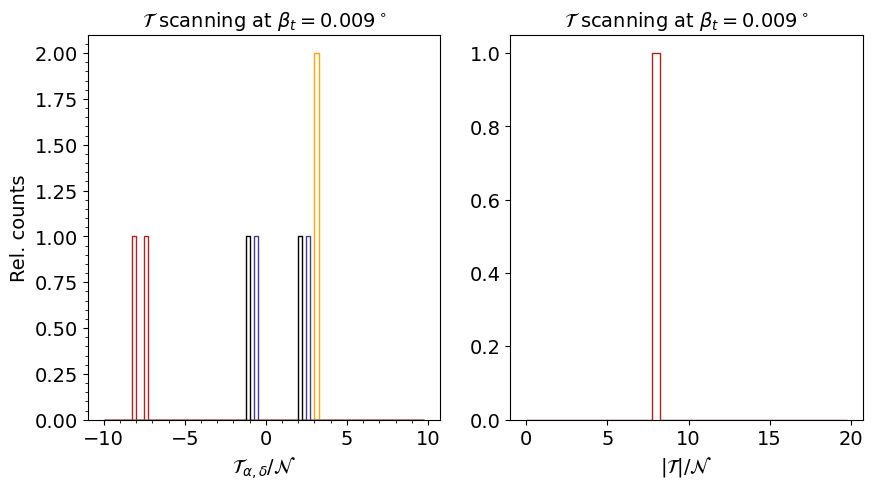

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
colorlist = ['firebrick', 'darkslateblue', 'orange']
xmin, xmax, nbins = -10, 10, 80
bins = np.arange(xmin,xmax, (xmax-xmin)/nbins)

ax[0].minorticks_on()
ax[0].hist(large_tau[:,ind_tau_ra]/large_tau[:,ind_n], bins=bins, histtype='step', linewidth=1, color=colorlist[0]);
ax[0].hist(large_tau[:,ind_tau_dec]/large_tau[:,ind_n], bins=bins, histtype='step', linewidth=1, color=colorlist[1]);
ax[0].hist(large_tau[:,ind_tau_par]/large_tau[:,ind_par_n], bins=bins, histtype='step', linewidth=1, color=colorlist[2]);
ax[0].hist(large_tau[:,ind_tau_mon]/large_tau[:,ind_tau_mon_n], bins=bins, histtype='step', linewidth=1, color='k');
ax[0].set_xlabel(r'$\mathcal{T}_{\alpha, \delta}/\mathcal{N}$'); ax[0].set_ylabel(r'Rel. counts'); 
ax[0].set_title(r'$\mathcal{T}$ scanning at $\beta_t = 0.009^\circ$', fontsize=14);

xmin, xmax, nbins = 0, 20, 80
bins = np.arange(xmin,xmax, (xmax-xmin)/nbins)
ax[1].hist(np.sqrt(large_tau[:,ind_tau_ra]**2 + large_tau[:,ind_tau_dec]**2)/large_tau[:,ind_n], bins=bins, histtype='step', linewidth=1, color=colorlist[0]);
ax[1].set_xlabel(r'$|\mathcal{T}|/\mathcal{N}$');
ax[1].set_title(r'$\mathcal{T}$ scanning at $\beta_t = 0.009^\circ$', fontsize=14);

### Look at the stars

In [96]:
### Import the data
data = pd.read_csv(DataDir+'LMC_disc_5_final.csv')  

In [97]:
len(large_tau)

2

In [141]:
tau_ind = 1; 
print(large_tau[tau_ind, ind_ra], large_tau[tau_ind, ind_dec])
large_tau[tau_ind, ind_tau_ra]/large_tau[tau_ind, ind_n], large_tau[tau_ind, ind_tau_dec]/large_tau[tau_ind, ind_n], large_tau[tau_ind, ind_tau_par]/large_tau[tau_ind, ind_par_n], large_tau[tau_ind, ind_tau_mon]/large_tau[tau_ind, ind_tau_mon_n]

84.91501115478593 -69.73661010208588


(-8.210426410766425,
 -0.6505126614681739,
 3.0172564774779054,
 -1.0234830886848019)

In [142]:
n_betat = 3
ra_min, ra_max = large_tau[tau_ind, ind_ra] - n_betat*beta_t/degree/np.cos(large_tau[tau_ind, ind_dec]*degree), large_tau[tau_ind, ind_ra] + n_betat*beta_t/degree/np.cos(large_tau[tau_ind, ind_dec]*degree)
dec_min, dec_max = large_tau[tau_ind, ind_dec] - n_betat*beta_t/degree, large_tau[tau_ind, ind_dec] + n_betat*beta_t/degree
data_zoom = data[(data['ra'].to_numpy() > ra_min) & (data['ra'].to_numpy() < ra_max) & (data['dec'].to_numpy() > dec_min) & (data['dec'].to_numpy() < dec_max)]
data_zoom.shape

(958, 7)

In [143]:
pix_size, coord, pmra_field, pmdec_field, parallax_field = fn_motion_field(data_zoom, beta_pixel=0.01*beta_t, sub=True, eff=True)
np.min(pmra_field), np.max(pmra_field), np.mean(pmra_field)

(-2.6866589406080594, 8.39672063963796, 0.024882472170591897)

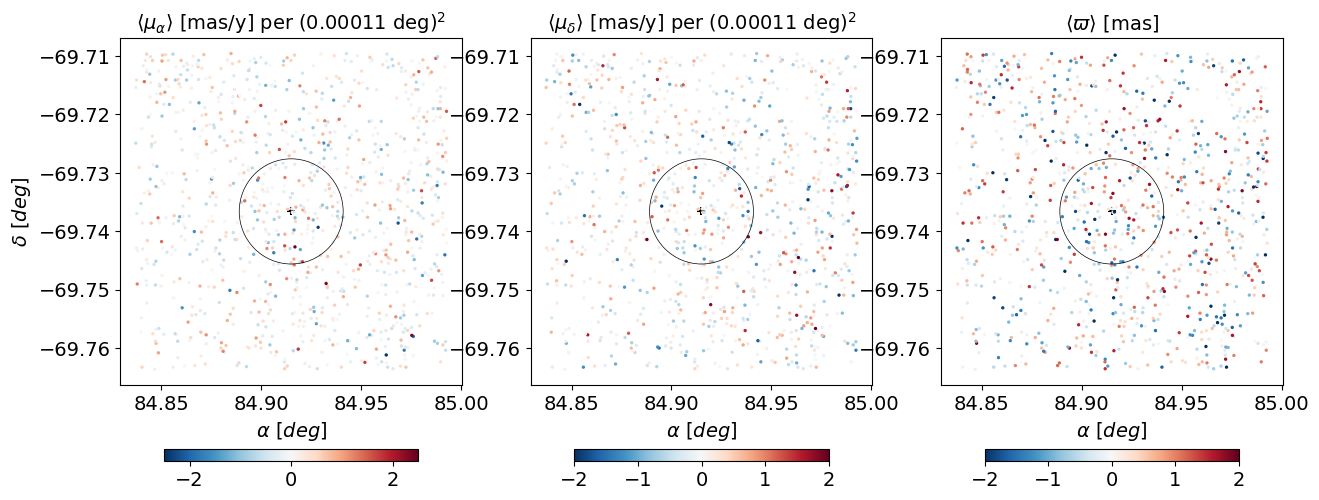

In [144]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1, 3,figsize=(15,5.5))
colormap = 'RdBu_r'
normalize = colors.Normalize(vmin=-2.5, vmax=2.5)
ax[0].scatter(np.array(large_tau[tau_ind, ind_ra]), np.array(large_tau[tau_ind, ind_dec]), s=30, marker='+', c='k');
image = ax[0].scatter(coord[0], coord[1], s=2, alpha=1, c=pmra_field, cmap=colormap, norm=normalize)
#ax[0].invert_xaxis()
ax[0].set_xlabel(r'$\alpha\ [deg]$'); ax[0].set_ylabel(r'$\delta\ [deg]$'); 
cbar = fig.colorbar(image, ax=ax[0], orientation="horizontal",fraction=0.03);
ax[0].set_title(r'$\langle \mu_\alpha\rangle\ [\mathrm{mas/y}]$ per ('+str(pix_size)[:7]+' deg$)^2$', fontsize=14);
ellipse = Ellipse(xy=(large_tau[tau_ind, ind_ra], large_tau[tau_ind, ind_dec]), width=2*beta_t/degree/np.cos(large_tau[tau_ind, ind_dec]*degree), height=2*beta_t/degree, 
                        edgecolor='k', fc='None', lw=0.5)
ax[0].add_patch(ellipse); 

normalize = colors.Normalize(vmin=-2, vmax=2)
ax[1].scatter(np.array(large_tau[tau_ind, ind_ra]), np.array(large_tau[tau_ind, ind_dec]), s=30, marker='+', c='k');
image = ax[1].scatter(coord[0], coord[1], s=2, alpha=1, c=pmdec_field, cmap=colormap, norm=normalize)
#ax[1].invert_xaxis()
ax[1].set_xlabel(r'$\alpha\ [deg]$'); 
cbar = fig.colorbar(image, ax=ax[1], orientation="horizontal",fraction=0.03);
ax[1].set_title(r'$\langle \mu_\delta\rangle\ [\mathrm{mas/y}]$ per ('+str(pix_size)[:7]+' deg$)^2$', fontsize=14);
ellipse = Ellipse(xy=(large_tau[tau_ind, ind_ra], large_tau[tau_ind, ind_dec]), width=2*beta_t/degree/np.cos(large_tau[tau_ind, ind_dec]*degree), height=2*beta_t/degree, 
                        edgecolor='k', fc='None', lw=0.5)
ax[1].add_patch(ellipse);

normalize = colors.Normalize(vmin=-2, vmax=2)
ax[2].scatter(np.array(large_tau[tau_ind, ind_ra]), np.array(large_tau[tau_ind, ind_dec]), s=30, marker='+', c='k');
image = ax[2].scatter(coord[0], coord[1], s=2, alpha=1, c=parallax_field, cmap=colormap, norm=normalize)
ax[2].set_xlabel(r'$\alpha\ [deg]$'); 
cbar = fig.colorbar(image, ax=ax[2], orientation="horizontal",fraction=0.03);
ax[2].set_title(r'$\langle \varpi \rangle\ [\mathrm{mas}]$', fontsize=14);
ellipse = Ellipse(xy=(large_tau[tau_ind, ind_ra], large_tau[tau_ind, ind_dec]), width=2*beta_t/degree/np.cos(large_tau[tau_ind, ind_dec]*degree), height=2*beta_t/degree, 
                        edgecolor='k', fc='None', lw=0.5)
ax[2].add_patch(ellipse);

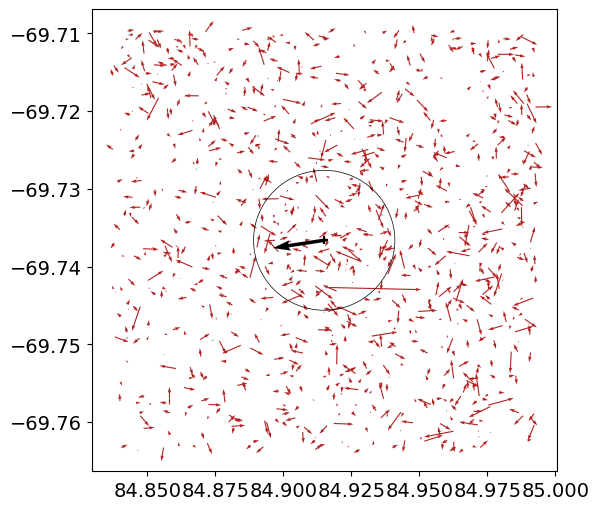

In [145]:
fig, ax = plt.subplots(1, 1,figsize=(6,6))
colormap = 'RdBu_r'
normalize = colors.Normalize(vmin=-4, vmax=4)
ax.quiver(coord[0], coord[1], pmra_field, pmdec_field, color='firebrick');
ax.scatter(np.array(large_tau[tau_ind, ind_ra]), np.array(large_tau[tau_ind, ind_dec]), s=30, marker='+', c='k');
ellipse = Ellipse(xy=(large_tau[tau_ind, ind_ra], large_tau[tau_ind, ind_dec]), width=2*beta_t/degree/np.cos(large_tau[tau_ind, ind_dec]*degree), height=2*beta_t/degree, 
                        edgecolor='k', fc='None', lw=0.5)
v0_LMC = -np.array([4.41243874e-04, 6.68110714e-05]) # -v_observer
ax.quiver(large_tau[tau_ind, ind_ra], large_tau[tau_ind, ind_dec], v0_LMC[0], v0_LMC[1], color='k', scale=0.004);


ax.add_patch(ellipse); 
#ax.invert_xaxis()
#ax.quiver(coord[0], coord[1], pmra_field/np.sqrt(pmra_field**2+pmdec_field**2), pmdec_field/np.sqrt(pmra_field**2+pmdec_field**2));

#quiver([X, Y], U, V, [C], **kw)

# Tests

## Check stars in a particular location

In [ ]:
ax[0].scatter(np.array([[77.30801717, 76.88487501, 80.7034131 , 80.70924488, 76.89265327]]), 
              np.array([-69.60969774, -70.66195832, -71.72703541, -71.71546721, -70.65037229]), s=30, facecolors='none', edgecolors='r');


In [63]:
point_coord = [76.88487501, -70.66195832]; radius = 3*0.02*degree
#point_coord = [80.7034131, -71.72703541]; radius = 3*0.02*degree
n = math.ceil(math.log(np.sqrt(np.pi/3)/(0.002*degree), 2)); nside = 2**n; 
vec = hp.pix2vec(nside, hp.ang2pix(nside, point_coord[0], point_coord[1], nest=True, lonlat=True), nest=True)
disc_pix = hp.query_disc(nside, vec, radius, nest=True, inclusive=True) # pixels on the sky within a disc with the edge

In [58]:
q_pix = np.asarray(hp.ang2pix(nside, data['ra'].to_numpy(), data['dec'].to_numpy(), nest=True, lonlat=True)) # healpy pixel number of the stars 

In [64]:
stars_in_disc = np.isin(q_pix, disc_pix, assume_unique=False)
data[stars_in_disc]

ra        dec      pmra     pmdec  parallax  pmra_error  \
11447092  76.776079 -70.620140  2.064710 -0.162041 -0.029827    0.091591   
11447094  76.767101 -70.614329  1.901987 -0.391941 -0.351114    0.200953   
11447095  76.756678 -70.619251  1.853406  0.492401 -0.030439    0.117898   
11447100  76.762469 -70.619779  2.009639 -1.310889  0.341489    0.258835   
11447145  76.762439 -70.617583  2.052869 -0.229922  0.135489    0.117269   
...             ...        ...       ...       ...       ...         ...   
11800618  76.898756 -70.601639  1.882040  0.137091 -1.016409    0.803059   
11800629  76.894135 -70.603913  1.203402 -1.228816 -0.704571    1.170662   
11800630  76.898628 -70.602152  2.151519 -0.603534  0.006729    0.199993   
11800787  76.897543 -70.603716  2.194137  0.250888  0.087220    0.189293   
11800789  76.900315 -70.601719  1.064641 -1.372227 -0.386457    1.147606   

          pmdec_error  parallax_error  pmra_pmdec_corr  parallax_pmra_corr  \
11447092     0.121735        0.076682         0.188392            0.240657   
11447094     0.310513        0.182757         0.245583            0.088101   
11447095     0.155761        0.095199         0.217599            0.177231   
11447100     0.365152        0.213377         0.225387            0.168756   
11447145     0.167032        0.095996         0.262277            0.159408   
...               ...             ...              ...                 ...   
11800618     1.429914        0.721665        -0.000622            0.210836   
11800629     2.544896        1.047014         0.224609            0.283342   
11800630     0.270817        0.172839         0.197771            0.280128   
11800787     0.257202        0.161373         0.203714            0.300354   
11800789     2.529271        0.898533        -0.144669            0.149593   

          parallax_pmdec_corr  phot_g_mean_mag      ruwe  \
11447092            -0.174768        17.709200  1.015397   
11447094            -0.313684        19.013483  0.983093   
11447095            -0.171516        18.077482  1.080606   
11447100            -0.197607        19.100578  1.251170   
11447145            -0.201064        18.158089  0.999429   
...                       ...              ...       ...   
11800618            -0.243091        20.443377  1.015413   
11800629            -0.020461        20.735876  1.103931   
11800630            -0.189447        18.944164  0.989156   
11800787            -0.203341        18.881771  0.941094   
11800789             0.155405        20.806086  0.931229   

          ipd_gof_harmonic_amplitude  ipd_frac_multi_peak  ipd_frac_odd_win  \
11447092                    0.036973                    0                 0   
11447094                    0.055603                    0                34   
11447095                    0.041020                    0                 0   
11447100                    0.060143                    0                 0   
11447145                    0.043061                    0                 0   
...                              ...                  ...               ...   
11800618                    0.022955                    0                30   
11800629                    0.133429                    0                35   
11800630                    0.068359                    1                 0   
11800787                    0.023386                    0                 0   
11800789                    0.046783                    0                12   

          pmra_sub  pmdec_sub  parallax_sub  
11447092 -0.009514  -0.231970     -0.028923  
11447094 -0.172933  -0.459964     -0.350123  
11447095 -0.220198   0.424593     -0.029288  
11447100 -0.064028  -1.379346      0.342566  
11447145 -0.021295  -0.298059      0.136557  
...            ...        ...           ...  
11800618 -0.200076   0.058323     -1.016526  
11800629 -0.878323  -1.307418     -0.704681  
11800630  0.069460  -0.682348      0.006608  
11800787  0.112264   0.171994      0.

In [65]:
np.min(data[stars_in_disc]['pmra_sub']), np.max(data[stars_in_disc]['pmra_sub']), np.min(data[stars_in_disc]['pmdec_sub']), np.max(data[stars_in_disc]['pmdec_sub'])

(-7.983212511656712, 7.212526930833131, -8.123657341987236, 9.195286664750707)

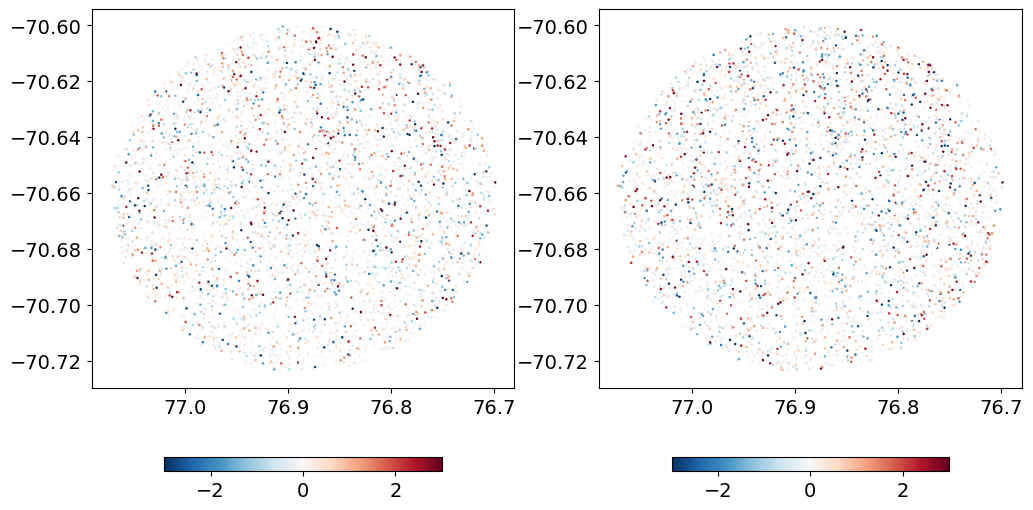

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
colormap = 'RdBu_r'
normalize = colors.Normalize(vmin=-3, vmax=3)
image = ax[0].scatter(data[stars_in_disc]['ra'], data[stars_in_disc]['dec'], s=0.6, alpha=1, c=data[stars_in_disc]['pmra_sub'], cmap=colormap, norm=normalize)
cbar = fig.colorbar(image, ax=ax[0], orientation="horizontal", fraction=0.03);
ax[0].invert_xaxis()
normalize = colors.Normalize(vmin=-3, vmax=3)
image = ax[1].scatter(data[stars_in_disc]['ra'], data[stars_in_disc]['dec'], s=0.6, alpha=1, c=data[stars_in_disc]['pmdec_sub'], cmap=colormap, norm=normalize)
cbar = fig.colorbar(image, ax=ax[1], orientation="horizontal", fraction=0.03);
ax[1].invert_xaxis()
#ax[0].set_xlabel(r'$\alpha\ [deg]$'); ax[0].set_ylabel(r'$\delta\ [deg]$')
#ax[0].set_title(r'$\langle \varpi\rangle\ [\mathrm{mas}]$ per ('+str(pix_size)[:5]+' deg$)^2$', fontsize=14);


## Equatorial to ecliptic coordinate transformation

In [75]:
df_back_g3 = pd.read_csv(DataDir+'pairs_background.csv')
df_fore = pd.read_csv(DataDir+'pairs_foreground.csv')

From https://gea.esac.esa.int/archive/documentation/GEDR3/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html and section 1.5.3 of https://www.cosmos.esa.int/documents/532822/552851/vol1_all.pdf

In [242]:
n_stars = 2
df_back_g3['ra'].to_numpy()[:n_stars], df_back_g3['dec'].to_numpy()[:n_stars], df_back_g3['ecl_lon'].to_numpy()[:n_stars], df_back_g3['ecl_lat'].to_numpy()[:n_stars]

(array([45.50600571, 44.53016294]),
 array([0.49545628, 1.87153399]),
 array([43.19021058, 42.63857136]),
 array([-16.0096721 , -14.40902604]))

In [239]:
#ra_s, dec_s = df_back_g3['ra'].to_numpy()[:n_stars] + ra_offset, df_back_g3['dec'].to_numpy()[:n_stars]*degree
ra_s, dec_s = df_back_g3['ra'].to_numpy()[0]*degree + ra_offset, df_back_g3['dec'].to_numpy()[0]*degree
x_vec_eq = np.array([np.cos(dec_s)*np.cos(ra_s), np.cos(dec_s)*np.sin(ra_s), np.sin(dec_s)])
x_vec_eq

array([0.7008081 , 0.71329743, 0.00864724])

In [244]:
#ra_s, dec_s = df_back_g3['ra'].to_numpy()[:n_stars] + ra_offset, df_back_g3['dec'].to_numpy()[:n_stars]*degree
ra_s, dec_s = df_back_g3['ra'].to_numpy()[:n_stars]*degree + ra_offset, df_back_g3['dec'].to_numpy()[:n_stars]*degree
x_vec_eq = np.array([np.cos(dec_s)*np.cos(ra_s), np.cos(dec_s)*np.sin(ra_s), np.sin(dec_s)])
x_vec_eq.T

array([[0.7008081 , 0.71329743, 0.00864724],
       [0.7125009 , 0.70091075, 0.03265862]])

In [240]:
x_vec_ecl = rot_matrix @ x_vec_eq
x_vec_ecl

array([ 0.7008081 ,  0.65787732, -0.27579962])

In [248]:
x_vec_ecl = (rot_matrix @ x_vec_eq).T
x_vec_ecl

array([[ 0.7008081 ,  0.65787732, -0.27579962],
       [ 0.7125009 ,  0.65606394, -0.24884247]])

In [250]:
x_vec_ecl[:, 0]

array([0.7008081, 0.7125009])

In [241]:
ecl_lon, ecl_lat = (np.arctan2(x_vec_ecl[1], x_vec_ecl[0])), np.arctan2(x_vec_ecl[2], np.sqrt(x_vec_ecl[0]**2 + x_vec_ecl[1]**2))
ecl_lon = ecl_lon + 2*np.pi*np.heaviside(-ecl_lon, 0) ### shifting the interval from [-pi, pi] to [0, 2*pi]
ecl_lon/degree, ecl_lat/degree

(43.19021058221582, -16.009672099703096)

In [251]:
ecl_lon, ecl_lat = (np.arctan2(x_vec_ecl[:, 1], x_vec_ecl[:, 0])), np.arctan2(x_vec_ecl[:, 2], np.sqrt(x_vec_ecl[:, 0]**2 + x_vec_ecl[:, 1]**2))
ecl_lon = ecl_lon + 2*np.pi*np.heaviside(-ecl_lon, 0) ### shifting the interval from [-pi, pi] to [0, 2*pi]
ecl_lon/degree, ecl_lat/degree

(array([43.19021058, 42.63857136]), array([-16.0096721 , -14.40902604]))

In [181]:
rot_matrix = np.array([[1, 0, 0], [0, 0.9174821334228558, 0.39777699135300065], [0, -0.39777699135300065, 0.9174821334228558]])
ra_offset = 0.05542*arcsec
    
def fn_eq_to_ecl(ra, dec):
    ra_s, dec_s = ra*degree + ra_offset, dec*degree
    x_vec_eq = np.array([np.cos(dec_s)*np.cos(ra_s), np.cos(dec_s)*np.sin(ra_s), np.sin(dec_s)])
    x_vec_ecl = rot_matrix @ x_vec_eq
    
    ecl_lon, ecl_lat = (np.arctan2(x_vec_ecl[1], x_vec_ecl[0])), np.arctan2(x_vec_ecl[2], np.sqrt(x_vec_ecl[0]**2 + x_vec_ecl[1]**2))
    ecl_lon = ecl_lon + 2*np.pi*np.heaviside(-ecl_lon, 0) ### shifting the interval from [-pi, pi] to [0, 2*pi]

    return ecl_lon/degree, ecl_lat/degree

In [252]:
rot_matrix = np.array([[1, 0, 0], [0, 0.9174821334228558, 0.39777699135300065], [0, -0.39777699135300065, 0.9174821334228558]])
ra_offset = 0.05542*arcsec
    
def fn_eq_to_ecl_array(ra, dec):
    ra_s, dec_s = ra*degree + ra_offset, dec*degree
    x_vec_eq = np.array([np.cos(dec_s)*np.cos(ra_s), np.cos(dec_s)*np.sin(ra_s), np.sin(dec_s)])
    x_vec_ecl = (rot_matrix @ x_vec_eq).T
    
    ecl_lon, ecl_lat = (np.arctan2(x_vec_ecl[:, 1], x_vec_ecl[:, 0])), np.arctan2(x_vec_ecl[:, 2], np.sqrt(x_vec_ecl[:, 0]**2 + x_vec_ecl[:, 1]**2))
    ecl_lon = ecl_lon + 2*np.pi*np.heaviside(-ecl_lon, 0) ### shifting the interval from [-pi, pi] to [0, 2*pi]

    return ecl_lon/degree, ecl_lat/degree

In [123]:
fn_eq_to_ecl(df_back_g3['ra'][0], df_back_g3['dec'][0]), df_back_g3['ecl_lon'][0], df_back_g3['ecl_lat'][0]

((43.19021058221582, -16.620657771675344),
 43.190210582215826,
 -16.0096720997031)

In [258]:
n_stars = 100000
conv_ecl_ra, conv_ecl_dec = fn_eq_to_ecl_array(df_back_g3['ra'].to_numpy()[:n_stars], df_back_g3['dec'].to_numpy()[:n_stars])
#conv_ecl_ra/df_back_g3['ecl_lon'].to_numpy()[:n_stars], conv_ecl_dec/df_back_g3['ecl_lat'].to_numpy()[:n_stars]

In [257]:
for i in tqdm(range(0, 100000)):
    true_ecl_ra, true_ecl_dec = df_back_g3['ecl_lon'][i], df_back_g3['ecl_lat'][i]
    
    conv_ecl_ra, conv_ecl_dec = fn_eq_to_ecl(df_back_g3['ra'][i], df_back_g3['dec'][i])
    
    #print(np.abs((true_ecl_ra-conv_ecl_ra)*np.cos(df_back_g3['dec'][i]*degree))/mas / df_back_g3['ra_error'][i])
    #print(np.abs(true_ecl_dec-conv_ecl_dec)/mas / df_back_g3['dec_error'][i])
    
    #if np.abs((true_ecl_ra-conv_ecl_ra)*np.cos(df_back_g3['dec'][i]*degree))/mas > df_back_g3['ra_error'][i]:
    #    print(np.abs(true_ecl_ra-conv_ecl_ra)/muas)
    #    print(true_ecl_ra, true_ecl_dec, conv_ecl_ra, conv_ecl_dec)
    #if np.abs(true_ecl_dec-conv_ecl_dec)/mas > df_back_g3['dec_error'][i]:
    #    print(np.abs(true_ecl_dec-conv_ecl_dec)/muas)

100%|██████████| 100000/100000 [00:03<00:00, 30413.82it/s]


## Parallel

In [7]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
print(num_cores)

8


In [65]:
### Running things in parallel

from joblib import Parallel, delayed
import multiprocessing

inputs = range(len(list_files[1752:])) 

num_cores = 8 #multiprocessing.cpu_count()

tic = tictoc()
out = Parallel(n_jobs=num_cores)(delayed(fn_execute)(i_f) for i_f in tqdm(inputs))
toc = tictoc()
print(toc - tic)
#print(out)

[     0      1      2      3  70997  70999  92842  92843 147455]
[     0      1      2      3  70997  92842  92843 147455]
[     0      1      2      3  70997  70999  92842 147455]
